In [428]:
from qcportal import PortalClient
from openff.qcsubmit.results import BasicResultCollection
import numpy as np
from matplotlib import pyplot as plt
client = PortalClient(address="https://api.qcarchive.molssi.org:443/")

In [214]:
client.query_singlepoints()

In [215]:
dataset_qcp = client.get_dataset(dataset_name='OpenFF NAGL2 ESP Timing Benchmark v1.1',dataset_type='SinglePoint')

In [216]:
dataset_qcp.status()

{'pbe0/def2-TZVPPD': {<RecordStatusEnum.complete: 'complete'>: 1009},
 'pbe0/def2-TZVPPD/ddx-water': {<RecordStatusEnum.complete: 'complete'>: 664,
  <RecordStatusEnum.error: 'error'>: 345},
 'wb97x-d/def2-TZVPP': {<RecordStatusEnum.complete: 'complete'>: 1009},
 'wb97x-d/def2-TZVPPD': {<RecordStatusEnum.complete: 'complete'>: 1009},
 'wb97x-d/def2-TZVPPD/ddx-water': {<RecordStatusEnum.complete: 'complete'>: 974,
  <RecordStatusEnum.error: 'error'>: 35},
 'wb97x-d/def2-TZVPP/ddx-water': {<RecordStatusEnum.complete: 'complete'>: 1009}}

# PBE0/def2-TZVPPD

This was my first attempted theory level. PBE0 was selected due to good performance on electrostatic properties, and def2-TZVPPD was selected as diffuse functions should be important for anions, and the second set of polarized functions should be important for hypervalent atoms.

Unfortunately, as shown below, 1/3 of the ~1000 PCM calculations using Psi4's DDX package errored out due to convergence issues, or converged to the wrong wavefunction. These were identified to be numerical issues presumably caused by the interaction between the diffuse wavefunction and the solvent. For a couple of especially hard-to-converge calculations, using a non-diffuse basis set with PCM, increasing the cavity size (using UFF radii with a 1.2x scaling factor), and using ddPCM in PySCF did not give the same errors. 

I picked 4 test calculations that were hard to fix and used these as local test cases. 1 calculation was fixable using a different initial guess or reading in the vacuum wavefunction, but it was not a generalizable solution. 4/4 test molecules to converge using the keyword `dft_bs_radius_alpha 5`, which extends the radial grid extent. However, further testing on other molecules revealed that this did not always help, especially for I-containing molecules.

## "Successful" calculations

Note all these either finished or errored out--none currently running.

In [8]:
ddx_dataset_pbe0 = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='pbe0/def2-TZVPPD/ddx-water')

In [9]:
vac_dataset_pbe0 = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='pbe0/def2-TZVPPD')

In [10]:
ddx_dataset_pbe0.n_results

664

In [11]:
vac_dataset_pbe0.n_results

1009

In [12]:
ddx_dataset_pbe0_records = ddx_dataset_pbe0.to_records()

In [16]:
vac_dataset_pbe0_records = vac_dataset_pbe0.to_records()

In [17]:
ddx_pbe0_mol_ids = [record[0].molecule_id for record in ddx_dataset_pbe0_records]

In [18]:
vac_pbe0_mol_ids = [record[0].molecule_id for record in vac_dataset_pbe0_records if record[0].molecule_id in ddx_pbe0_mol_ids]

In [19]:
vac_records_pbe0_w_ddx = [record for record in vac_dataset_pbe0_records if record[0].molecule_id in ddx_pbe0_mol_ids]

In [74]:
n_mbis_diff = 0
n_mbis_diff_i = 0
n_lowdin_diff = 0
n_mulliken_diff = 0
n_dipole_diff = 0
for i,record in enumerate(ddx_dataset_pbe0_records):
    ddx_record = record[0]
    vac_record = vac_records_pbe0_w_ddx[i][0]
    if vac_record.molecule_id != ddx_record.molecule_id: print('False') # Always True

    ddx_mbis = np.array(ddx_record.properties['mbis charges'])
    vac_mbis = np.array(vac_record.properties['mbis charges'])
    
    ddx_lowdin = np.array(ddx_record.properties['lowdin charges'])
    vac_lowdin = np.array(vac_record.properties['lowdin charges'])

    ddx_mulliken = np.array(ddx_record.properties['mulliken charges'])
    vac_mulliken = np.array(vac_record.properties['mulliken charges'])

    ddx_dipole = np.array(ddx_record.properties['pbe0 dipole'])
    vac_dipole = np.array(vac_record.properties['pbe0 dipole'])
    if np.any(np.abs(vac_mbis - ddx_mbis) > 1) :
        print(record[1].to_smiles())
        print(ddx_mbis)
        print(vac_mbis)
        print(np.abs(vac_mbis - ddx_mbis))
        n_mbis_diff += 1
        if "I" in record[1].to_smiles():
            n_mbis_diff_i += 1
    
    elif np.any(np.abs(vac_lowdin - ddx_lowdin) > 1):
        print(record[1].to_smiles())
        print(ddx_lowdin)
        print(vac_lowdin)
        print(np.abs(vac_lowdin - ddx_lowdin))
        n_lowdin_diff += 1

    elif np.any(np.abs(vac_mulliken - ddx_mulliken) > 1):
        print(record[1].to_smiles())
        print(ddx_mulliken)
        print(vac_mulliken)
        print(np.abs(vac_mulliken - ddx_mulliken))
        n_mulliken_diff += 1
    
    elif np.any(np.abs(vac_dipole - ddx_dipole) > 3):
        print(record[1].to_smiles())
        print(ddx_dipole)
        print(vac_dipole)
        print(np.abs(vac_dipole - ddx_dipole))
        n_dipole_diff += 1

[H]c1c(c(c(c(c1[H])I)[H])C#N)[H]
[  1.           3.60031156   2.85232584   2.38561488   3.12157664
   3.88654878   2.8239613  -10.90453539   2.43361449 -16.35612666
   0.31259664   4.17740115   0.6666496 ]
[ 0.15602108 -0.13456854 -0.12563828 -0.02197516 -0.10464107 -0.08764206
 -0.09317167  0.16498806 -0.00313427  0.17829563  0.32812837 -0.42071874
  0.16405501]
[8.43978917e-01 3.73488010e+00 2.97796412e+00 2.40759004e+00
 3.22621771e+00 3.97419083e+00 2.91713297e+00 1.10695234e+01
 2.43674876e+00 1.65344223e+01 1.55317273e-02 4.59811989e+00
 5.02594590e-01]
[H]c1c(c(c(nc1[H])Br)I)[H]
[  1.           3.91306394   3.9425604    2.57785436   2.49849821
   2.99060192   1.10186381   0.8093061   -1.52489838  -3.49412554
 -13.81361521]
[ 0.170136   -0.2498774  -0.02578518 -0.19979317  0.32610849 -0.37770589
  0.14849117  0.11751963 -0.10831896  0.03685203  0.16244543]
[ 0.829864    4.16294134  3.96834557  2.77764753  2.17238972  3.36830781
  0.95337263  0.69178647  1.41657941  3.53097757 13.

In [75]:
print('MBIS differences:     ', n_mbis_diff,n_mbis_diff_i)
print('Lowdin differences:   ',n_lowdin_diff)
print('Mulliken differences: ',n_mulliken_diff)
print('Dipole differences:   ', n_dipole_diff)

MBIS differences:      51 13
Lowdin differences:    0
Mulliken differences:  0
Dipole differences:    0


Tried 0.15, 0.25, and 0.5 as boundaries. 0.15 < diff < 0.5 seemed fine. 0.5 < diff only yielded differences larger than ~6. I decided to use 1 just for flexibility.

For dipole, using 2 as a cutoff worked well for PBE0, but 2 < diff < 3 yielded 2 seemingly normal looking results for wb97x-d so it was increased

Luckily not too many of the sucessful calculations are secretly buggy.

## Errored calculations

In [88]:
print('PBE0 errors:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='error'):
    if 'pbe0/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)
print('')
print('PBE0 waiting:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='waiting'):
    if 'pbe0/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)

print('')
print('PBE0 running:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='running'):
    if 'pbe0/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)

PBE0 errors:
C(C[NH3+])C(C=O)O pbe0/def2-TZVPPD/ddx-water
C1=C(SC(=C1N)C=O)Br pbe0/def2-TZVPPD/ddx-water
C1=CSC(=C1)C(=O)C(N)O pbe0/def2-TZVPPD/ddx-water
C1=NC2=C(N1)C(=O)NC=N2 pbe0/def2-TZVPPD/ddx-water
C1=NNC(=C1CCO)C(=O)[O-] pbe0/def2-TZVPPD/ddx-water
C1CC1CC2=NC=C(S2)C=O pbe0/def2-TZVPPD/ddx-water
C1CCCC(CCC1)C(C=O)O pbe0/def2-TZVPPD/ddx-water
C1COCC[NH+]1CC(C[NH3+])O pbe0/def2-TZVPPD/ddx-water
C1C[NH+](CCN1)CCO pbe0/def2-TZVPPD/ddx-water
CC(C)(C)CCC(CO)[NH3+] pbe0/def2-TZVPPD/ddx-water
CC(C)C1=CSC(=N1)C[NH3+] pbe0/def2-TZVPPD/ddx-water
CC(CC1=CC=CS1)C[NH3+] pbe0/def2-TZVPPD/ddx-water
CC([NH3+])S(=O)(=O)[O-] pbe0/def2-TZVPPD/ddx-water
CC12CC3C(C1)C3C2 pbe0/def2-TZVPPD/ddx-water
CC1=C(C(=NN1)CC(C)C)C=O pbe0/def2-TZVPPD/ddx-water
CC1=C(NC(=O)NC1=O)S(=O)[O-] pbe0/def2-TZVPPD/ddx-water
CC1=C(SC=N1)S(=O)(=O)N pbe0/def2-TZVPPD/ddx-water
CC1CCC2=C(C1)SC(=N2)C pbe0/def2-TZVPPD/ddx-water
CC1CCCCC1[NH+](C)C pbe0/def2-TZVPPD/ddx-water
CC1COCC(N1C)(CN)CO pbe0/def2-TZVPPD/ddx-water
CCC1=NNC(=C1

In [91]:
mbis_err = []
scf_conv_err = []
adiis_err = []
i_errs = []
for e_name, s_name, record in dataset_qcp.iterate_records(status='error'): # All calcs errored so no need to check anything else
    if 'pbe0/def2-TZVPPD/ddx-water' == s_name:
        if "I" in e_name:
            i_errs.append((e_name,s_name))
        if 'could not converge MBIS' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            mbis_err.append((e_name,s_name))
        elif 'Could not converge SCF iterations in 200 iterations' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            scf_conv_err.append((e_name,s_name))
        elif 'ADIIS minimization failed' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            adiis_err.append((e_name,s_name))
        else:
            print(e_name,s_name)       

In [90]:
print('MBIS convergence error:  ',len(mbis_err))
print('SCF convergence error:   ',len(scf_conv_err))
print('ADIIS convergence error: ',len(adiis_err))
print("total errors with I:     ",len(i_errs))

MBIS convergence error:   209
SCF convergence error:    113
ADIIS convergence error:  23
total errors with I:      22


## Examining some error messages

In [17]:
print(dataset_qcp.get_record('C(C[NH3+])C(C=O)O', 'pbe0/def2-TZVPPD/ddx-water').error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [18]:
print(dataset_qcp.get_record('C1COCC[NH+]1CC(C[NH3+])O', 'pbe0/def2-TZVPPD/ddx-water').error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [19]:
print(dataset_qcp.get_record('CC([NH3+])S(=O)(=O)[O-]', 'pbe0/def2-TZVPPD/ddx-water').error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [22]:
print(dataset_qcp.get_record(scf_conv_err[2][0], scf_conv_err[2][1]).error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [23]:
print(dataset_qcp.get_record(mbis_err[1][0], mbis_err[1][1]).error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [19]:
scf_conv_err_i = [entry for entry in scf_conv_err if 'I' in entry[0]]

In [20]:
scf_conv_err_i

[('C1=C(SC(=N1)N)I', 'pbe0/def2-TZVPPD/ddx-water'),
 ('Cc1cc(c(c(c1)I)N)C', 'pbe0/def2-TZVPPD/ddx-water'),
 ('CSc1cc(cnc1)I', 'pbe0/def2-TZVPPD/ddx-water')]

In [50]:
print(dataset_qcp.get_record(scf_conv_err_i[2][0],scf_conv_err_i[2][1]).error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [23]:
mbis_err_i = [entry for entry in mbis_err if 'I' in entry[0]]

In [24]:
len(mbis_err_i)

18

In [44]:
print(dataset_qcp.get_record(mbis_err_i[1][0],mbis_err_i[1][1]).molecule)

Molecule(name='C7H5IN2', formula='C7H5IN2', hash='32342aa')


In [49]:
print(dataset_qcp.get_record(mbis_err_i[5][0],mbis_err_i[5][1]).error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

In [51]:
mbis_err_i[5][1]

'pbe0/def2-TZVPPD/ddx-water'

In [54]:
print(dataset_qcp.get_record(mbis_err_i[3][0],'pbe0/def2-TZVPPD').stdout)


    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,
    J. F. Gonthier, R. 

In [21]:
adiis_err_i = [entry for entry in adiis_err if 'I' in entry[0]]

In [22]:
adiis_err_i

[('C1COC(C1I)CO', 'pbe0/def2-TZVPPD/ddx-water')]

In [34]:
print(dataset_qcp.get_record(adiis_err_i[0][0],adiis_err_i[0][1]).error['error_message'])

QCEngine Unknown Error: 
    -----------------------------------------------------------------------
          Psi4: An Open-Source Ab Initio Electronic Structure Package
                               Psi4 1.9.1 release

                         Git: Rev {} zzzzzzz 


    D. G. A. Smith, L. A. Burns, A. C. Simmonett, R. M. Parrish,
    M. C. Schieber, R. Galvelis, P. Kraus, H. Kruse, R. Di Remigio,
    A. Alenaizan, A. M. James, S. Lehtola, J. P. Misiewicz, M. Scheurer,
    R. A. Shaw, J. B. Schriber, Y. Xie, Z. L. Glick, D. A. Sirianni,
    J. S. O'Brien, J. M. Waldrop, A. Kumar, E. G. Hohenstein,
    B. P. Pritchard, B. R. Brooks, H. F. Schaefer III, A. Yu. Sokolov,
    K. Patkowski, A. E. DePrince III, U. Bozkaya, R. A. King,
    F. A. Evangelista, J. M. Turney, T. D. Crawford, C. D. Sherrill,
    J. Chem. Phys. 152(18) 184108 (2020). https://doi.org/10.1063/5.0006002

                            Additional Code Authors
    E. T. Seidl, C. L. Janssen, E. F. Valeev, M. L. Leininger,

# wb97x-D/def2-TZVPPD

This was my second attempted theory level, run with the keyword `dft_bs_radius_alpha 5`. 

For a set of 10 problematic molecules containing I that didn't converge with PBE0, this theory level was able to converge 7 out of 10 calculations, and 2 out of 3 errors were converged when using a Huckel initial guess.

On the ~1000 molecule test dataset (analyzed below), this level of theory performed much more reliably, with only 35 calculations failing to converge and 21 calculations converging to the wrong wavefunction. However, it showed an unacceptable failure rate on sulfonamide chemistries, which are of particular interest for this project.

## "Successful" calculations

In [2]:
ddx_dataset_wb97 = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='wb97x-d/def2-TZVPPD/ddx-water')

In [3]:
vac_dataset_wb97 = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='wb97x-d/def2-TZVPPD')

In [4]:
ddx_dataset_wb97.n_results

974

In [5]:
vac_dataset_wb97.n_results

1009

In [6]:
ddx_dataset_wb97_records = ddx_dataset_wb97.to_records()

In [7]:
vac_dataset_wb97_records = vac_dataset_wb97.to_records()

In [8]:
ddx_wb97_mol_ids = [record[0].molecule_id for record in ddx_dataset_wb97_records]

In [9]:
vac_wb97_mol_ids = [record[0].molecule_id for record in vac_dataset_wb97_records if record[0].molecule_id in ddx_wb97_mol_ids]

In [10]:
vac_records_wb97_w_ddx = [record for record in vac_dataset_wb97_records if record[0].molecule_id in ddx_wb97_mol_ids]

In [88]:
n_mbis_diff = 0
n_mbis_diff_i = 0
n_lowdin_diff = 0
n_mulliken_diff = 0
n_dipole_diff = 0
chgdif_qcaid = []
for i,record in enumerate(ddx_dataset_wb97_records):
    ddx_record = record[0]
    vac_record = vac_records_wb97_w_ddx[i][0]
    if vac_record.molecule_id != ddx_record.molecule_id: print('False') # Always True

    ddx_mbis = np.array(ddx_record.properties['mbis charges'])
    vac_mbis = np.array(vac_record.properties['mbis charges'])
    
    ddx_lowdin = np.array(ddx_record.properties['lowdin charges'])
    vac_lowdin = np.array(vac_record.properties['lowdin charges'])

    ddx_mulliken = np.array(ddx_record.properties['mulliken charges'])
    vac_mulliken = np.array(vac_record.properties['mulliken charges'])

    ddx_dipole = np.array(ddx_record.properties['wb97x-d dipole'])
    vac_dipole = np.array(vac_record.properties['wb97x-d dipole'])

    ddx_tot_energy = ddx_record.properties['scf_total_energy']
    vac_tot_energy = vac_record.properties['scf_total_energy']

    ddx_dft_energy = ddx_record.properties['dft total energy']
    vac_dft_energy = vac_record.properties['dft total energy']

    ddx_grid_e = ddx_record.properties['grid electrons total']
    vac_grid_e = vac_record.properties['grid electrons total']
    
    ddx_solv_energy = ddx_record.properties['dd solvation energy']
    if np.any(np.abs(vac_mbis - ddx_mbis) > 0.25):
        print('MBIS difference')
        print(record[1].to_smiles())
        print('DDX MBIS:', ddx_mbis)
        print('Vac MBIS:',vac_mbis)
        print('MBIS diff:',np.abs(vac_mbis - ddx_mbis))
        print('Lowd diff:',np.abs(vac_lowdin - ddx_lowdin))
        print('Mull diff:',np.abs(vac_mulliken - ddx_mulliken))
        print('Dip diff: ',np.abs(vac_dipole - ddx_dipole))
       
        print('Delta Etot:',vac_tot_energy-ddx_tot_energy)
        print('Delta Edft:',vac_dft_energy-ddx_dft_energy)
        print('Solv E:    ',ddx_solv_energy)

        print('Vac Nelec grid: ',vac_grid_e)
        print('DDX Nelec grid: ',ddx_grid_e)
        n_mbis_diff += 1
        chgdif_qcaid.append(vac_record.molecule_id)
        if "I" in record[1].to_smiles():
            n_mbis_diff_i += 1
    
    elif np.any(np.abs(vac_lowdin - ddx_lowdin) > 1):
        print(record[1].to_smiles())
        print(ddx_lowdin)
        print(vac_lowdin)
        print(np.abs(vac_lowdin - ddx_lowdin))
        n_lowdin_diff += 1
        chgdif_qcaid.append(vac_record.molecule_id)

    elif np.any(np.abs(vac_mulliken - ddx_mulliken) > 1):
        print(record[1].to_smiles())
        print(ddx_mulliken)
        print(vac_mulliken)
        print(np.abs(vac_mulliken - ddx_mulliken))
        n_mulliken_diff += 1
        chgdif_qcaid.append(vac_record.molecule_id)
    
    elif np.any(np.abs(vac_dipole - ddx_dipole) > 3):
        print('Dipole difference')
        print(record[1].to_smiles())
        print(ddx_dipole)
        print(vac_dipole)
        print('Dip diff: ',np.abs(vac_dipole - ddx_dipole))
        print('MBIS diff:',np.abs(vac_mbis - ddx_mbis))
        print('Lowd diff:',np.abs(vac_lowdin - ddx_lowdin))
        print('Mull diff:',np.abs(vac_mulliken - ddx_mulliken))

       
        print('Delta Etot:',vac_tot_energy-ddx_tot_energy)
        print('Delta Edft:',vac_dft_energy-ddx_dft_energy)
        print('Solv E:    ',ddx_solv_energy)
        n_dipole_diff += 1
        chgdif_qcaid.append(vac_record.molecule_id)

MBIS difference
[H]C(=O)C1(C(C(C1([H])[H])([H])S(=O)[O-])([H])[H])[H]
DDX MBIS: [  3.46647077   2.26686092   3.47357937  -3.03331159 -14.74555954
   1.79752383   0.15421668   3.22029772   3.07451424   1.
   1.           1.           1.           1.          -6.68680664
   1.        ]
Vac MBIS: [-1.99494129e-01 -2.62760646e-01 -1.99524385e-01 -1.20685544e-01
  3.05492161e-01 -6.18699981e-01 -6.18681110e-01  5.09610866e-01
 -5.27958464e-01  1.23590826e-01  1.05045484e-01  1.37093881e-01
  1.23588848e-01  1.05051308e-01  1.37680734e-01  5.50330966e-04]
MBIS diff: [ 3.6659649   2.52962157  3.67310375  2.91262604 15.0510517   2.41622382
  0.77289779  2.71068685  3.60247271  0.87640917  0.89495452  0.86290612
  0.87641115  0.89494869  6.82448737  0.99944967]
Lowd diff: [1.43722174 2.36921759 1.32872999 4.52128087 5.69795934 1.69271702
 3.06845379 2.78309772 3.39697658 0.72136496 0.71881995 0.7383949
 0.6944854  0.68900137 0.75288228 0.85598308]
Mull diff: [13.51359352  1.22789442 12.23291055

In [89]:
print('MBIS differences:     ', n_mbis_diff,n_mbis_diff_i)
print('Lowdin differences:   ',n_lowdin_diff)
print('Mulliken differences: ',n_mulliken_diff)
print('Dipole differences:   ', n_dipole_diff)

MBIS differences:      22 4
Lowdin differences:    0
Mulliken differences:  0
Dipole differences:    0


For PBE0, tried 0.15, 0.25, and 0.5 as boundaries. 0.15 < diff < 0.5 seemed fine. 0.5 < diff only yielded differences larger than ~6. 

However, for wb97x-d there was one  molecule with diff ~ 0.5 that has a solvation energy ~1 Ha (0.25 and 0.15 didn't look problematic). Everything looks "ok", I'm not sure if it's just really polar or there's an issue. I'm going to leave it out for now.

Luckily not too many of the sucessful calculations are secretly buggy.

## Errored molecules

In [217]:
print('wb97x-D errors:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='error'):
    if 'wb97x-d/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)
print('')
print('wb97x-D waiting:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='waiting'):
    if 'wb97x-d/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)

print('')
print('wb97x-D running:')
for e_name, s_name, record in dataset_qcp.iterate_records(status='running'):
    if 'wb97x-d/def2-TZVPPD/ddx-water' == s_name:
       print(e_name,s_name)

wb97x-D errors:
c1c2c(ncn1)N=C(N2)I wb97x-d/def2-TZVPPD/ddx-water
c1cc2c(cc1F)SC(=C2)C=O wb97x-d/def2-TZVPPD/ddx-water
C1CCC2=C(C1)C=C(S2)N wb97x-d/def2-TZVPPD/ddx-water
c1ccc2c(c1)NCNS2(=O)=O wb97x-d/def2-TZVPPD/ddx-water
C1CCC2(CC=CCC2(C1)[NH3+])I wb97x-d/def2-TZVPPD/ddx-water
c1cc(c(c(c1)I)C=O)Cl wb97x-d/def2-TZVPPD/ddx-water
c1cc(ccc1N)SCC(=[NH2+])N wb97x-d/def2-TZVPPD/ddx-water
c1cc(c(nc1)C=O)S(=O)(=O)N wb97x-d/def2-TZVPPD/ddx-water
c1cc(c(nc1)I)S(=O)(=O)N wb97x-d/def2-TZVPPD/ddx-water
C1=C(C(=O)NC(=O)N1)S wb97x-d/def2-TZVPPD/ddx-water
C1CN2C(=C(C=N2)S(=O)[O-])OC1 wb97x-d/def2-TZVPPD/ddx-water
C1CNCC1OS(=O)(=O)[O-] wb97x-d/def2-TZVPPD/ddx-water
c1cnc(cc1I)S(=O)(=O)N wb97x-d/def2-TZVPPD/ddx-water
C1COCC1CSC2=NN=CN2 wb97x-d/def2-TZVPPD/ddx-water
C1COC(C1I)CO wb97x-d/def2-TZVPPD/ddx-water
C1=CSC(=C1N)C(=O)[O-] wb97x-d/def2-TZVPPD/ddx-water
Cc1cccc(c1I)C=O wb97x-d/def2-TZVPPD/ddx-water
CC1=C(SC=N1)S(=O)(=O)N wb97x-d/def2-TZVPPD/ddx-water
CCC1=NC(=CS1)C[NH2+]C wb97x-d/def2-TZVPPD/ddx-w

In [218]:
mbis_err = []
scf_conv_err = []
adiis_err = []
i_errs = []
wb97_error_ids = []
for e_name, s_name, record in dataset_qcp.iterate_records(status='error'):
    if 'wb97x-d/def2-TZVPPD/ddx-water' == s_name:
        if "I" in e_name:
            i_errs.append((e_name,s_name))
        if 'could not converge MBIS' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            mbis_err.append((e_name,s_name))
        elif 'Could not converge SCF iterations in 200 iterations' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            scf_conv_err.append((e_name,s_name))
        elif 'ADIIS minimization failed' in dataset_qcp.get_record(e_name, s_name).error['error_message']:
            adiis_err.append((e_name,s_name))
        else:
            print(e_name,s_name)   
        wb97_error_ids.append(dataset_qcp.get_record(e_name, s_name).molecule_id)



In [219]:
print('MBIS convergence error:  ',len(mbis_err))
print('SCF convergence error:   ',len(scf_conv_err))
print('ADIIS convergence error: ',len(adiis_err))
print("total errors with I:     ",len(i_errs))

MBIS convergence error:   16
SCF convergence error:    19
ADIIS convergence error:  0
total errors with I:      8


In [220]:
len(wb97_error_ids)

35

Total there are 53 I-containing molecules, 8 crashed and 4 converged but gave large discrepencies between PCM and vacuum

In total, 35 errors + 21 charge differences = 56 issues out of 1009 conformers

## Investigate distribution of errors

In [209]:
from openff.qcsubmit.results import OptimizationResultCollection,BasicResultCollection
from openff.qcsubmit.datasets import BasicDataset
from openff.toolkit import Molecule
from matplotlib import pyplot as plt
from openff.units import unit

In [210]:
print(vac_dataset_wb97.n_results)

1009


In [211]:
len(vac_dataset_wb97_records)

1009

In [212]:
len(vac_records_wb97_w_ddx)

974

In [221]:
vac_records_wb97_good = []
vac_records_wb97_prob = []
vac_records_wb97_chgdif = []
vac_records_wb97_errs = []
for record in vac_dataset_wb97_records:
    if record[0].molecule_id in chgdif_qcaid:
        vac_records_wb97_prob.append(record)
        vac_records_wb97_chgdif.append(record)
    elif record[0].molecule_id in wb97_error_ids:
        vac_records_wb97_prob.append(record)
        vac_records_wb97_errs.append(record)
    else:
        vac_records_wb97_good.append(record)

In [222]:
len(vac_records_wb97_good)

952

In [223]:
len(vac_records_wb97_prob)

57

In [224]:
vac_records_wb97_prob[0][1].to_smiles()

'[H]c1c2c(nc(n1)[H])N=C(N2[H])I'

In [225]:
vac_smiles_wb97_all = [mol[1].to_smiles() for mol in vac_dataset_wb97_records]
vac_smiles_wb97_good = [mol[1].to_smiles() for mol in vac_records_wb97_good]
vac_smiles_wb97_prob = [mol[1].to_smiles() for mol in vac_records_wb97_prob]

In [226]:
ft_prob = len(vac_records_wb97_prob)/len(vac_dataset_wb97_records)
ft_good = len(vac_records_wb97_good)/len(vac_dataset_wb97_records)

In [227]:
int(1/ft_prob)

17

In [228]:
1/ft_prob

17.70175438596491

In [229]:
1/ft_good

1.059873949579832

In [33]:
int(1/ft_good)

1

In [381]:
ft_good

0.9435084241823588

### Molecular weight

In [230]:
all_mw = np.array([
    sum([atom.mass.m for atom in mol[1].atoms])
    for mol in vac_dataset_wb97_records
])

In [231]:
max(all_mw)

329.815488

In [232]:
good_mw = np.array([
    sum([atom.mass.m for atom in mol[1].atoms])
    for mol in vac_records_wb97_good
])

prob_mw = np.array([
    sum([atom.mass.m for atom in mol[1].atoms])
    for mol in vac_records_wb97_prob
])

chgdif_mw = np.array([
    sum([atom.mass.m for atom in mol[1].atoms])
    for mol in vac_records_wb97_chgdif
])

errs_mw = np.array([
    sum([atom.mass.m for atom in mol[1].atoms])
    for mol in vac_records_wb97_errs
])

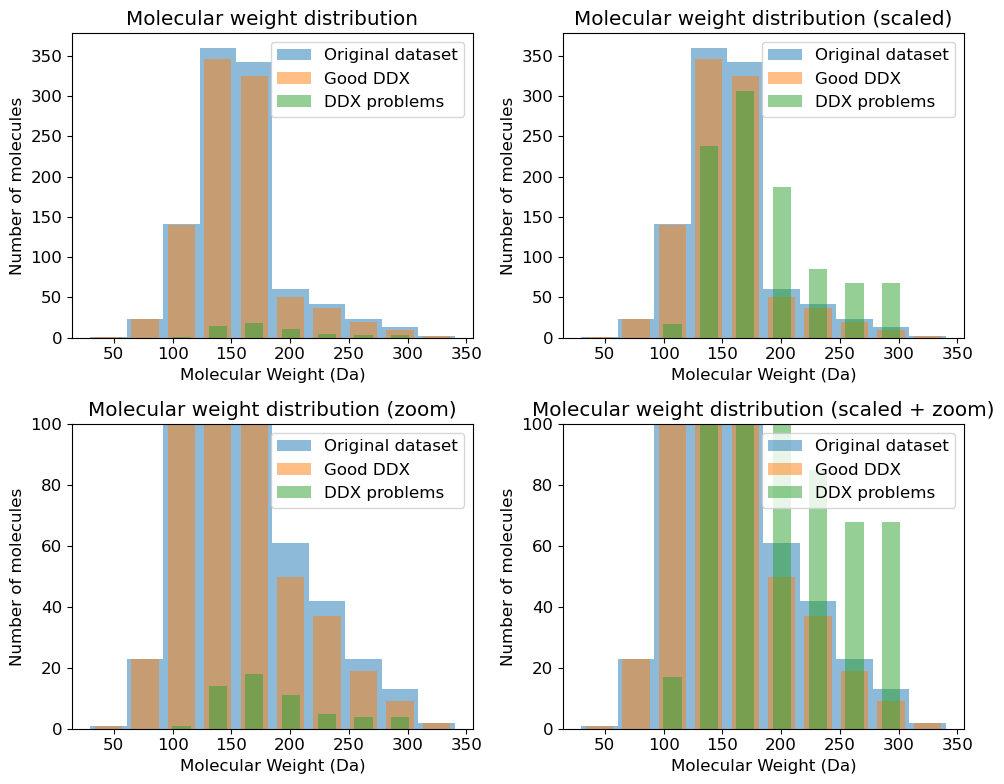

In [368]:
plt.rc('font', size=12) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=12)

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,8),sharey=False)
ax1.hist(all_mw,alpha = 0.5,range=(30,340),label='Original dataset')
ax1.hist(good_mw,alpha = 0.5,range=(30,340),rwidth=0.75,label='Good DDX')
ax1.hist(prob_mw,alpha = 0.5,range=(30,340),rwidth=0.5,label='DDX problems')
ax1.set_title('Molecular weight distribution')
ax1.set_xlabel("Molecular Weight (Da)")
ax1.set_ylabel('Number of molecules')
ax1.legend()

ax2.hist(all_mw,alpha = 0.5,range=(30,340),label='Original dataset')
ax2.hist(np.tile(good_mw,int(1/ft_good)),alpha = 0.5,range=(30,340),rwidth=0.75,label='Good DDX')
ax2.hist(np.tile(prob_mw,int(1/ft_prob)),alpha = 0.5,range=(30,340),rwidth=0.5,label='DDX problems')
ax2.set_title('Molecular weight distribution (scaled)')
ax2.set_xlabel("Molecular Weight (Da)")
ax2.set_ylabel('Number of molecules')
ax2.legend()

ax3.hist(all_mw,alpha = 0.5,range=(30,340),label='Original dataset')
ax3.hist(good_mw,alpha = 0.5,range=(30,340),rwidth=0.75,label='Good DDX')
ax3.hist(prob_mw,alpha = 0.5,range=(30,340),rwidth=0.5,label='DDX problems')
ax3.set_title('Molecular weight distribution (zoom)')
ax3.set_xlabel("Molecular Weight (Da)")
ax3.set_ylim(0,100)
ax3.set_ylabel('Number of molecules')
ax3.legend()

ax4.hist(all_mw,alpha = 0.5,range=(30,340),label='Original dataset')
ax4.hist(np.tile(good_mw,int(1/ft_good)),alpha = 0.5,range=(30,340),rwidth=0.75,label='Good DDX')
ax4.hist(np.tile(prob_mw,int(1/ft_prob)),alpha = 0.5,range=(30,340),rwidth=0.5,label='DDX problems')
ax4.set_title('Molecular weight distribution (scaled + zoom)')
ax4.set_xlabel("Molecular Weight (Da)")
ax4.set_ylim(0,100)
ax4.set_ylabel('Number of molecules')
ax4.legend()
plt.tight_layout()
plt.savefig('mw_dist.png')
plt.show()

It's ultimately a grid problem, so makes sense that it's more of an issue with larger systems.

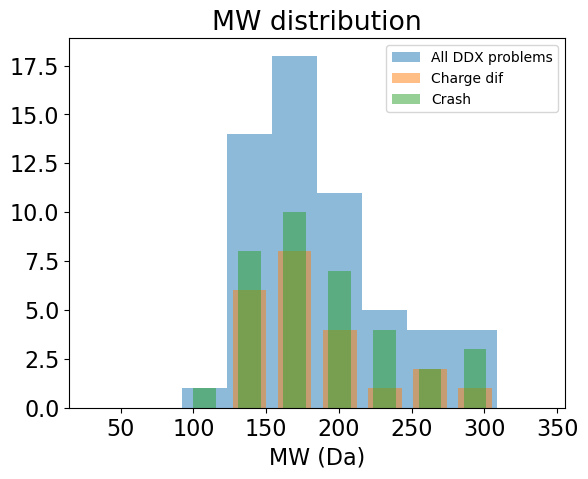

In [235]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=10)

plt.figure()
plt.hist(prob_mw,alpha = 0.5,range=(30,340),label='All DDX problems')
plt.hist(chgdif_mw,alpha = 0.5,range=(30,340),rwidth=0.75,label='Charge dif')
plt.hist(errs_mw,alpha = 0.5,range=(30,340),rwidth=0.5,label='Crash')
plt.title('MW distribution')
plt.xlabel("MW (Da)")
plt.legend()
plt.show()

I don't think that's a substantial difference between the two populations

### Element distribution

In [236]:
atoms_all = []
atoms_unique_all = []
for mol in vac_dataset_wb97_records:
    atoms_all.extend([atom.symbol for atom in mol[1].atoms]) # each time an atom appears

    atoms_unique_all.extend(np.unique([atom.symbol for atom in mol[1].atoms])) # molecule contains x atom


In [237]:
atoms_good = []
atoms_unique_good = []
for mol in vac_records_wb97_good:
    atoms_good.extend([atom.symbol for atom in mol[1].atoms]) # each time an atom appears

    atoms_unique_good.extend(np.unique([atom.symbol for atom in mol[1].atoms])) # molecule contains x atom


atoms_prob = []
atoms_unique_prob = []
for mol in vac_records_wb97_prob:
    atoms_prob.extend([atom.symbol for atom in mol[1].atoms]) # each time an atom appears

    atoms_unique_prob.extend(np.unique([atom.symbol for atom in mol[1].atoms])) # molecule contains x atom


In [238]:
atoms_all_labels,atoms_all_counts = np.unique(atoms_all,return_counts=True)
atoms_good_labels_scaled,atoms_good_counts_scaled = np.unique(np.tile(atoms_good,int(1/ft_good)),return_counts=True)
atoms_good_labels,atoms_good_counts = np.unique(atoms_good,return_counts=True)
atoms_prob_labels_scaled,atoms_prob_counts_scaled = np.unique(np.tile(atoms_prob,int(1/ft_prob)),return_counts=True)
atoms_prob_labels,atoms_prob_counts = np.unique(atoms_prob,return_counts=True)

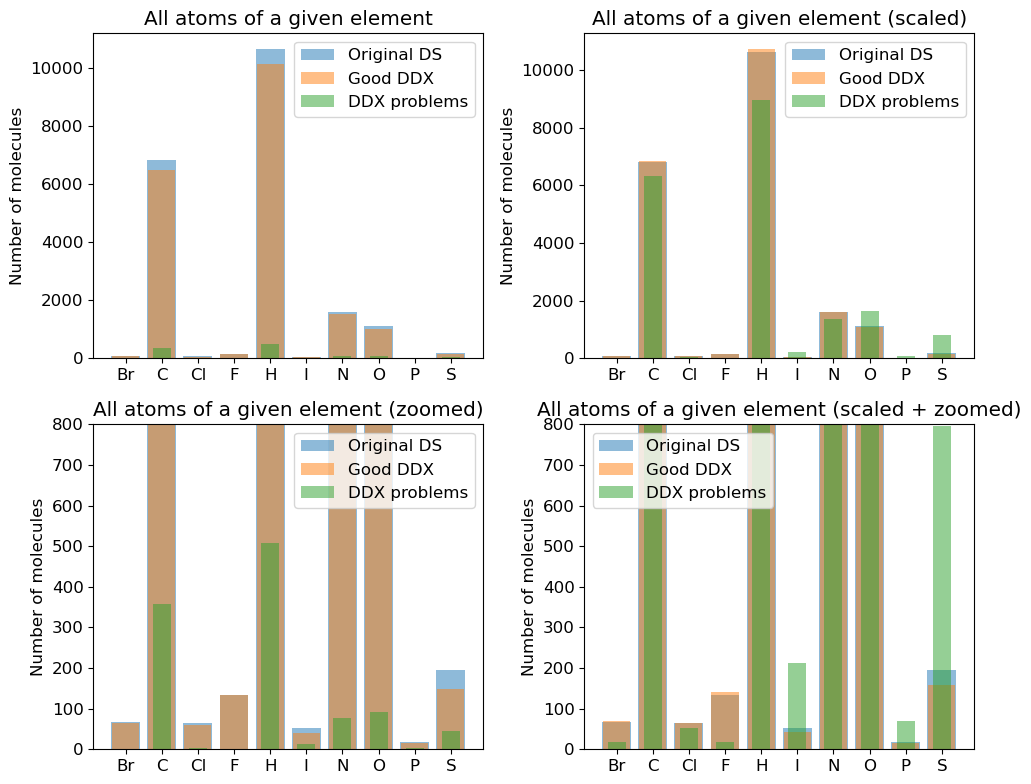

In [366]:
plt.rc('font', size=12) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=12)

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,8))
ax1.bar(atoms_all_labels,atoms_all_counts,alpha = 0.5,label='Original DS')
ax1.bar(atoms_good_labels,atoms_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
ax1.bar(atoms_prob_labels,atoms_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
ax1.legend()
ax1.set_title("All atoms of a given element")
ax1.set_ylabel('Number of molecules')

ax2.bar(atoms_all_labels,atoms_all_counts,alpha = 0.5,label='Original DS')
ax2.bar(atoms_good_labels,atoms_good_counts*1/ft_good,alpha = 0.5,width=0.75,label='Good DDX')
ax2.bar(atoms_prob_labels,atoms_prob_counts*1/ft_prob,alpha = 0.5,width=0.5, label = 'DDX problems')
ax2.legend()
ax2.set_title("All atoms of a given element (scaled)")
ax2.set_ylabel('Number of molecules')

ax3.bar(atoms_all_labels,atoms_all_counts,alpha = 0.5,label='Original DS')
ax3.bar(atoms_good_labels,atoms_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
ax3.bar(atoms_prob_labels,atoms_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
ax3.legend()
ax3.set_title("All atoms of a given element (zoomed)")
ax3.set_ylabel('Number of molecules')
ax3.set_ylim(0,800)

ax4.bar(atoms_all_labels,atoms_all_counts,alpha = 0.5,label='Original DS')
ax4.bar(atoms_good_labels,atoms_good_counts*1/ft_good,alpha = 0.5,width=0.75,label='Good DDX')
ax4.bar(atoms_prob_labels,atoms_prob_counts*1/ft_prob,alpha = 0.5,width=0.5, label = 'DDX problems')
ax4.legend()
ax4.set_title("All atoms of a given element (scaled + zoomed)")
ax4.set_ylabel('Number of molecules')
ax4.set_ylim(0,800)

plt.tight_layout()
plt.show()

In [265]:
atoms_unique_labels,atoms_unique_counts = np.unique(atoms_unique_all,return_counts=True)
atoms_unique_good_labels_scaled,atoms_unique_good_counts_scaled = np.unique(np.tile(atoms_unique_good,int(1/ft_good)),return_counts=True)
atoms_unique_good_labels,atoms_unique_good_counts = np.unique(atoms_unique_good,return_counts=True)
atoms_unique_prob_labels_scaled,atoms_unique_prob_counts_scaled = np.unique(np.tile(atoms_unique_prob,int(1/ft_prob)),return_counts=True)
atoms_unique_prob_labels,atoms_unique_prob_counts = np.unique(atoms_unique_prob,return_counts=True)

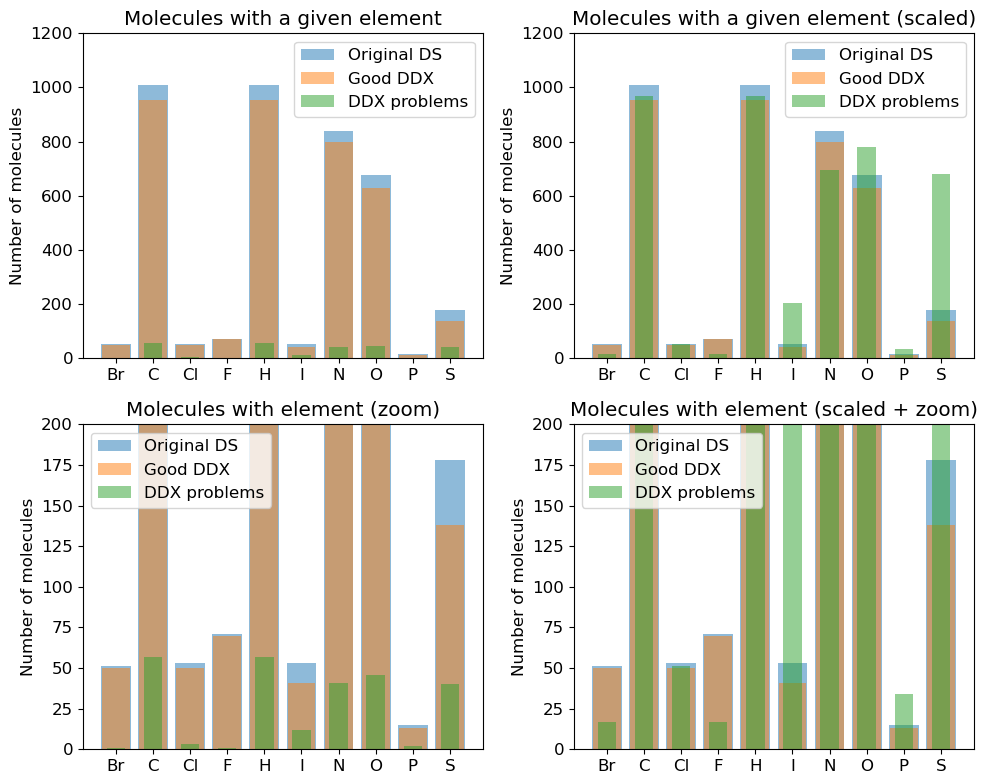

In [373]:
plt.rc('font', size=12) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=12)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,8))
ax1.bar(atoms_unique_labels,atoms_unique_counts,alpha = 0.5,label='Original DS')
ax1.bar(atoms_unique_good_labels,atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
ax1.bar(atoms_unique_prob_labels,atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
ax1.legend()
ax1.set_ylim(0,1200)
ax1.set_title("Molecules with a given element")
ax1.set_ylabel('Number of molecules')

ax2.bar(atoms_unique_labels,atoms_unique_counts,alpha = 0.5,label='Original DS')
ax2.bar(atoms_unique_good_labels_scaled,atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX')
ax2.bar(atoms_unique_prob_labels_scaled,atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems')
ax2.legend()
ax2.set_ylim(0,1200)
ax2.set_title("Molecules with a given element (scaled)")
ax2.set_ylabel('Number of molecules')

ax3.bar(atoms_unique_labels,atoms_unique_counts,alpha = 0.5,label='Original DS')
ax3.bar(atoms_unique_good_labels,atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
ax3.bar(atoms_unique_prob_labels,atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
ax3.legend()
ax3.set_title("Molecules with element (zoom)")
ax3.set_ylabel('Number of molecules')
ax3.set_ylim(0,200)

ax4.bar(atoms_unique_labels,atoms_unique_counts,alpha = 0.5,label='Original DS')
ax4.bar(atoms_unique_good_labels_scaled,atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX')
ax4.bar(atoms_unique_prob_labels_scaled,atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems')
ax4.legend()
ax4.set_title("Molecules with element (scaled + zoom)")
ax4.set_ylabel('Number of molecules')
ax4.set_ylim(0,200)

plt.tight_layout()
plt.savefig('atom_dist.png')
plt.show()


### Charge

In [269]:
all_charges =[
    mol[1].total_charge.m_as(unit.elementary_charge)
    for mol in vac_dataset_wb97_records
]

good_charges =[
    mol[1].total_charge.m_as(unit.elementary_charge)
    for mol in vac_records_wb97_good
]

prob_charges =[
    mol[1].total_charge.m_as(unit.elementary_charge)
    for mol in vac_records_wb97_prob
]

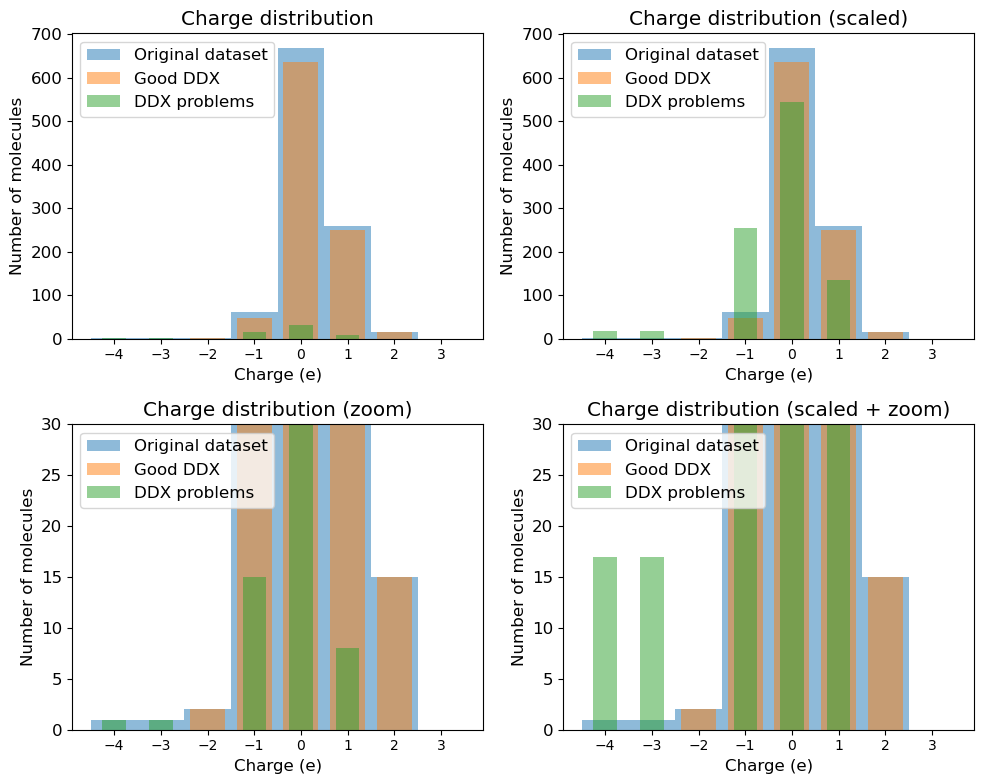

In [377]:
plt.rc('font', size=12) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=10)

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,8))
ax1.hist(all_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,label='Original dataset')
ax1.hist(good_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.75,label='Good DDX')
ax1.hist(prob_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.5,label='DDX problems')
ax1.set_title('Charge distribution')
ax1.set_xlabel("Charge (e)")
ax1.set_ylabel('Number of molecules')
ax1.legend()

ax2.hist(all_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,label='Original dataset')
ax2.hist(np.tile(good_charges,int(1/ft_good)),alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.75,label='Good DDX')
ax2.hist(np.tile(prob_charges,int(1/ft_prob)),alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.5,label='DDX problems')
ax2.set_title('Charge distribution (scaled)')
ax2.set_xlabel("Charge (e)")
ax2.set_ylabel('Number of molecules')
ax2.legend()

ax3.hist(all_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,label='Original dataset')
ax3.hist(good_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.75,label='Good DDX')
ax3.hist(prob_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.5,label='DDX problems')
ax3.set_title('Charge distribution (zoom)')
ax3.set_xlabel("Charge (e)")
ax3.set_ylabel('Number of molecules')
ax3.legend()
ax3.set_ylim(0,30)

ax4.hist(all_charges,alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,label='Original dataset')
ax4.hist(np.tile(good_charges,int(1/ft_good)),alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.75,label='Good DDX')
ax4.hist(np.tile(prob_charges,int(1/ft_prob)),alpha = 0.5,range=(-4,4),bins=np.arange(-4,5)-0.5,rwidth=0.5,label='DDX problems')
ax4.set_title('Charge distribution (scaled + zoom)')
ax4.set_xlabel("Charge (e)")
ax4.set_ylabel('Number of molecules')
ax4.legend()
ax4.set_ylim(0,30)

plt.tight_layout()
plt.savefig('charge_dist.png')
plt.show()

### Charge + atom

In [79]:
charged_atoms_all = []

for mol in vac_dataset_wb97_records:
    charge = mol[1].total_charge.m_as(unit.elementary_charge)
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    charged_atoms_all.extend([str(charge) + '_' + atom for atom in atoms_unique])

charged_atoms_good = []

for mol in vac_records_wb97_good:
    charge = mol[1].total_charge.m_as(unit.elementary_charge)
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    charged_atoms_good.extend([str(charge) + '_' + atom for atom in atoms_unique])

charged_atoms_prob = []

for mol in vac_records_wb97_prob:
    charge = mol[1].total_charge.m_as(unit.elementary_charge)
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    charged_atoms_prob.extend([str(charge) + '_' + atom for atom in atoms_unique])


In [80]:
charged_atoms_unique_labels,charged_atoms_unique_counts = np.unique(charged_atoms_all,return_counts=True)
charged_atoms_unique_good_labels_scaled,charged_atoms_unique_good_counts_scaled = np.unique(np.tile(charged_atoms_good,int(1/ft_good)),return_counts=True)
charged_atoms_unique_good_labels,charged_atoms_unique_good_counts = np.unique(charged_atoms_good,return_counts=True)
charged_atoms_unique_prob_labels_scaled,charged_atoms_unique_prob_counts_scaled = np.unique(np.tile(charged_atoms_prob,int(1/ft_prob)),return_counts=True)
charged_atoms_unique_prob_labels,charged_atoms_unique_prob_counts = np.unique(charged_atoms_prob,return_counts=True)

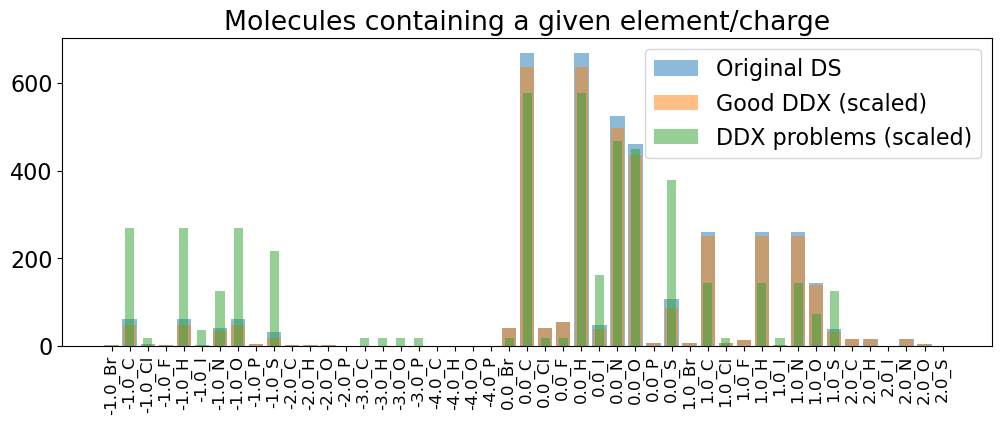

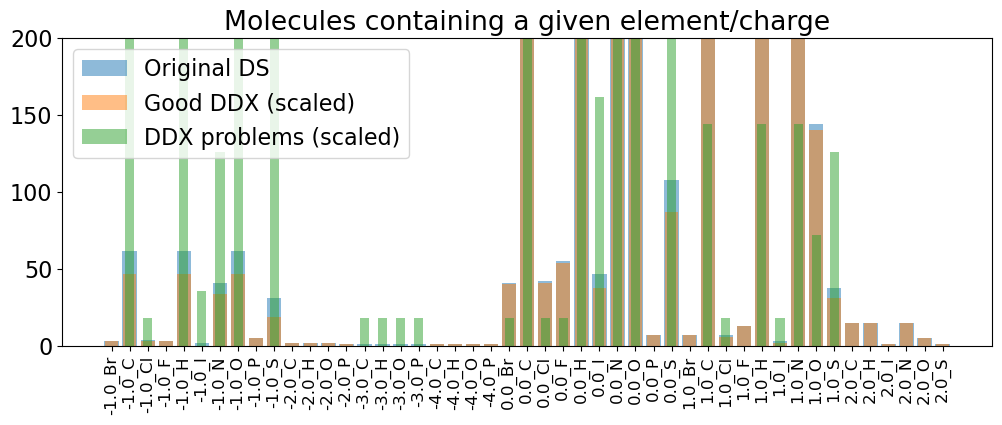

In [112]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=16)
plt.rc('xtick',labelsize=12)

plt.figure(figsize=(12,4))
plt.bar(charged_atoms_unique_labels,charged_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(charged_atoms_unique_good_labels_scaled,charged_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(charged_atoms_unique_prob_labels_scaled,charged_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
plt.xticks(rotation=90)
plt.title("Molecules containing a given element/charge")

plt.figure(figsize=(12,4))
plt.bar(charged_atoms_unique_labels,charged_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(charged_atoms_unique_good_labels_scaled,charged_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(charged_atoms_unique_prob_labels_scaled,charged_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
plt.title("Molecules containing a given element/charge")
plt.ylim(0,200)
plt.xticks(rotation=90)
plt.show()

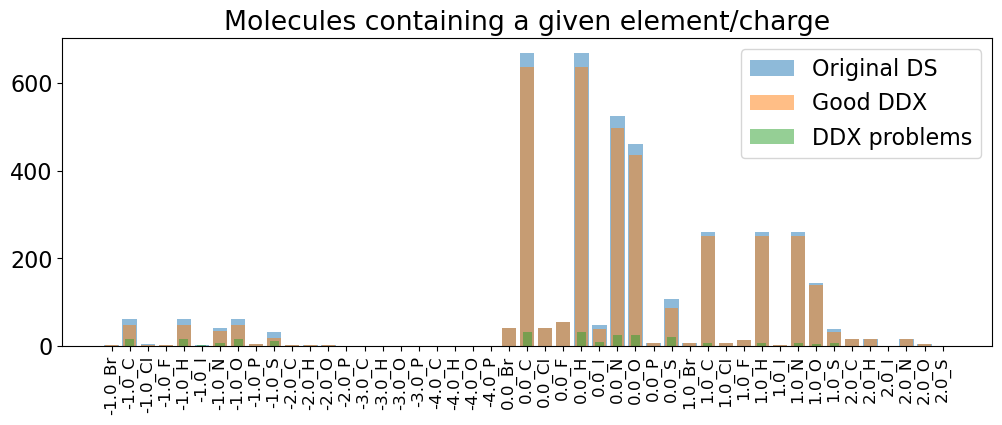

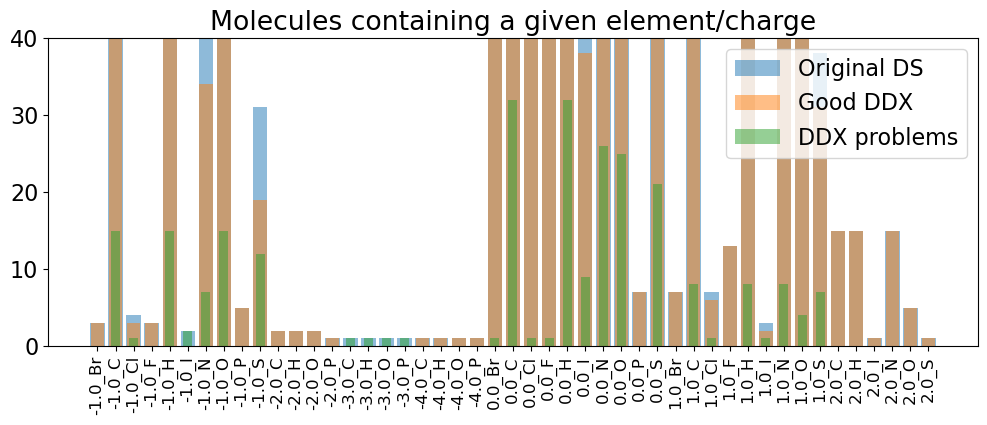

In [114]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=16)
plt.rc('xtick',labelsize=12)

plt.figure(figsize=(12,4))
plt.bar(charged_atoms_unique_labels,charged_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(charged_atoms_unique_good_labels,charged_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(charged_atoms_unique_prob_labels,charged_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
plt.xticks(rotation=90)
plt.title("Molecules containing a given element/charge")

plt.figure(figsize=(12,4))
plt.bar(charged_atoms_unique_labels,charged_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(charged_atoms_unique_good_labels,charged_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(charged_atoms_unique_prob_labels,charged_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
plt.title("Molecules containing a given element/charge")
plt.ylim(0,40)
plt.xticks(rotation=90)
plt.show()

Not eliminating 100% of anything

### Element + size

In [85]:
lg_atoms_all = []
sm_atoms_all = []

for mol in vac_dataset_wb97_records:
    mw = sum([atom.mass.m for atom in mol[1].atoms])
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    if mw > 200:
        lg_atoms_all.extend(atoms_unique)
    else:
        sm_atoms_all.extend(atoms_unique)

lg_atoms_good = []
sm_atoms_good = []

for mol in vac_records_wb97_good:
    mw = sum([atom.mass.m for atom in mol[1].atoms])
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    if mw > 200:
        lg_atoms_good.extend(atoms_unique)
    else:
        sm_atoms_good.extend(atoms_unique)

lg_atoms_prob = []
sm_atoms_prob = []

for mol in vac_records_wb97_prob:
    mw = sum([atom.mass.m for atom in mol[1].atoms])
    atoms_unique = np.unique([atom.symbol for atom in mol[1].atoms]) # molecule contains x atom
    if mw > 200:
        lg_atoms_prob.extend(atoms_unique)
    else:
        sm_atoms_prob.extend(atoms_unique)

In [86]:
lg_atoms_unique_labels,lg_atoms_unique_counts = np.unique(lg_atoms_all,return_counts=True)
lg_atoms_unique_good_labels_scaled,lg_atoms_unique_good_counts_scaled = np.unique(np.tile(lg_atoms_good,int(1/ft_good)),return_counts=True)
lg_atoms_unique_good_labels,lg_atoms_unique_good_counts = np.unique(lg_atoms_good,return_counts=True)
lg_atoms_unique_prob_labels_scaled,lg_atoms_unique_prob_counts_scaled = np.unique(np.tile(lg_atoms_prob,int(1/ft_prob)),return_counts=True)
lg_atoms_unique_prob_labels,lg_atoms_unique_prob_counts = np.unique(lg_atoms_prob,return_counts=True)

sm_atoms_unique_labels,sm_atoms_unique_counts = np.unique(sm_atoms_all,return_counts=True)
sm_atoms_unique_good_labels_scaled,sm_atoms_unique_good_counts_scaled = np.unique(np.tile(sm_atoms_good,int(1/ft_good)),return_counts=True)
sm_atoms_unique_good_labels,sm_atoms_unique_good_counts = np.unique(sm_atoms_good,return_counts=True)
sm_atoms_unique_prob_labels_scaled,sm_atoms_unique_prob_counts_scaled = np.unique(np.tile(sm_atoms_prob,int(1/ft_prob)),return_counts=True)
sm_atoms_unique_prob_labels,sm_atoms_unique_prob_counts = np.unique(sm_atoms_prob,return_counts=True)

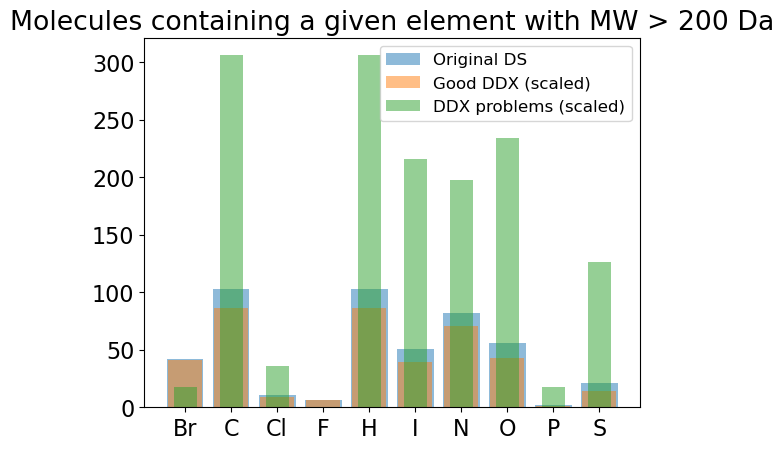

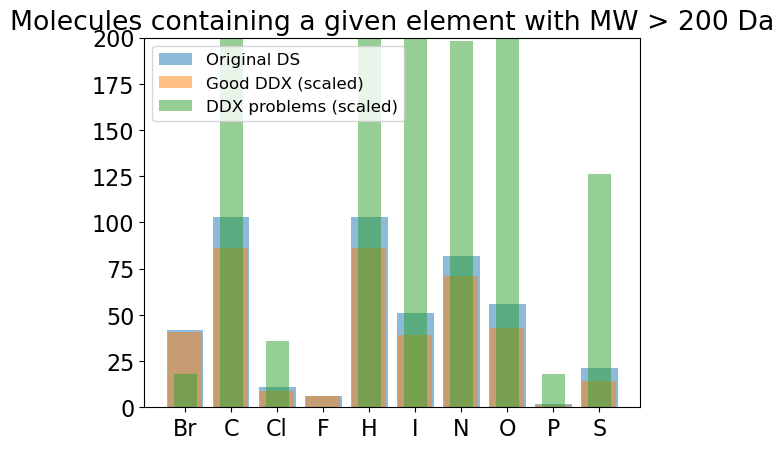

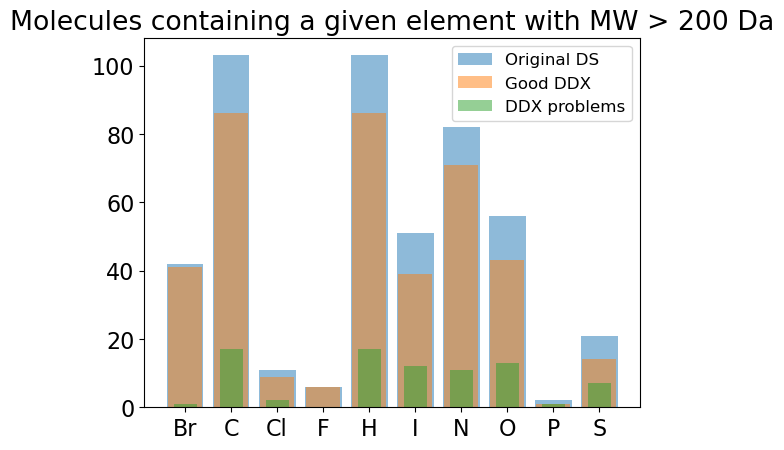

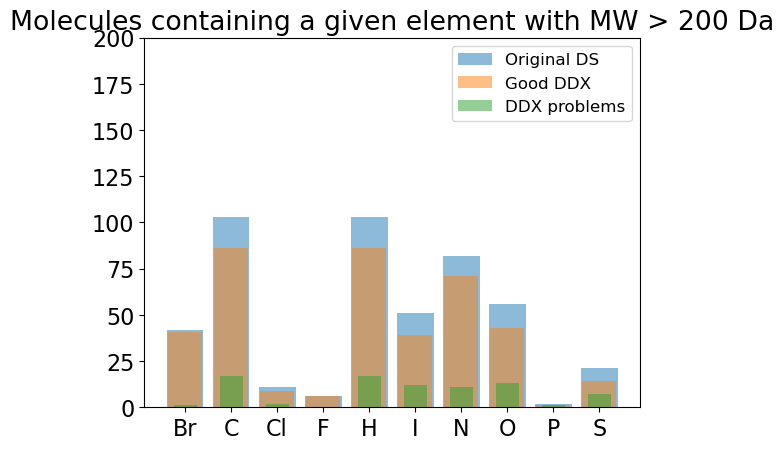

In [116]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=16)

plt.figure()
plt.bar(lg_atoms_unique_labels,lg_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(lg_atoms_unique_good_labels_scaled,lg_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(lg_atoms_unique_prob_labels_scaled,lg_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
# plt.xticks(rotation=90)
plt.title("Molecules containing a given element with MW > 200 Da")

plt.figure()
plt.bar(lg_atoms_unique_labels,lg_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(lg_atoms_unique_good_labels_scaled,lg_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(lg_atoms_unique_prob_labels_scaled,lg_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
plt.title("Molecules containing a given element with MW > 200 Da")
plt.ylim(0,200)
# plt.xticks(rotation=90)
plt.show()

plt.figure()
plt.bar(lg_atoms_unique_labels,lg_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(lg_atoms_unique_good_labels,lg_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(lg_atoms_unique_prob_labels,lg_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
# plt.xticks(rotation=90)
plt.title("Molecules containing a given element with MW > 200 Da")

plt.figure()
plt.bar(lg_atoms_unique_labels,lg_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(lg_atoms_unique_good_labels,lg_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(lg_atoms_unique_prob_labels,lg_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
plt.title("Molecules containing a given element with MW > 200 Da")
plt.ylim(0,200)
# plt.xticks(rotation=90)
plt.show()

Only 2 large molecules have P, and one is errored

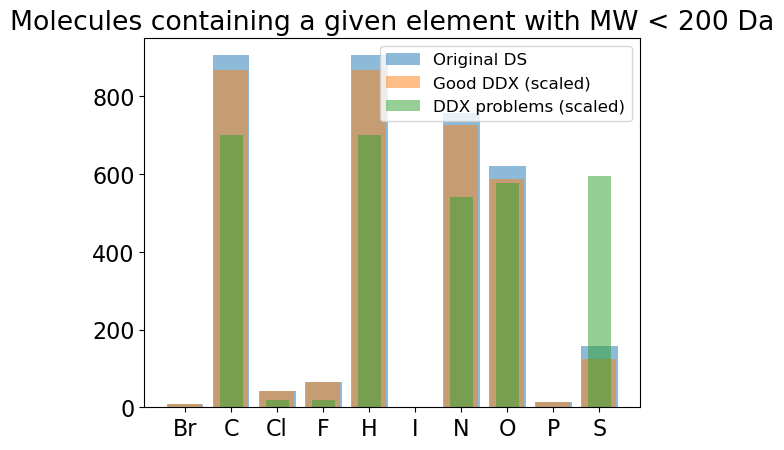

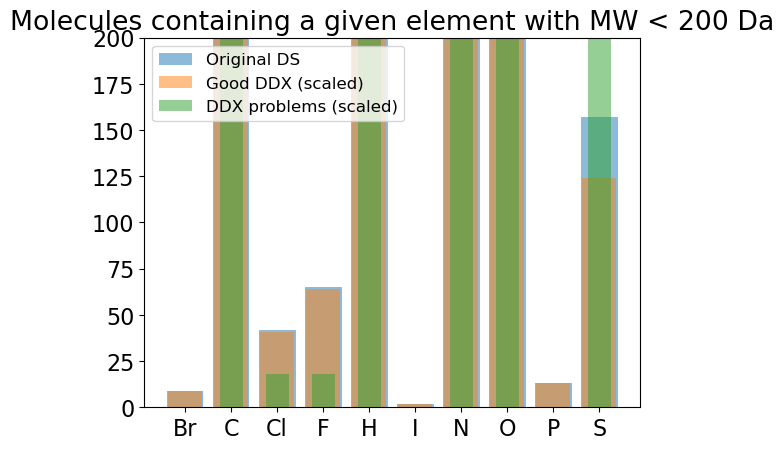

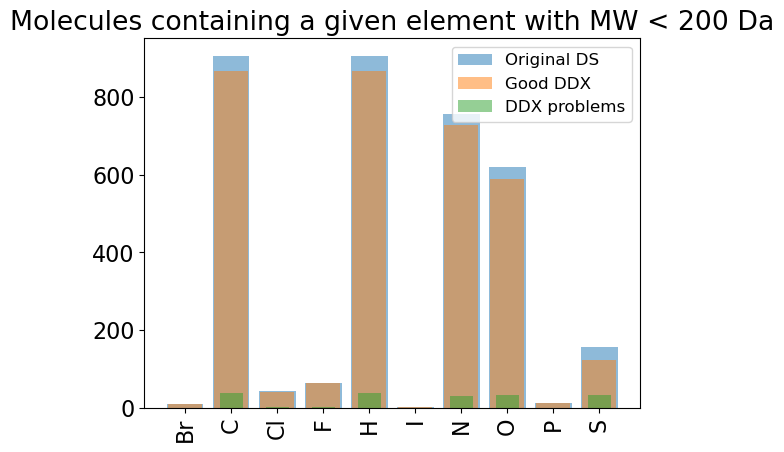

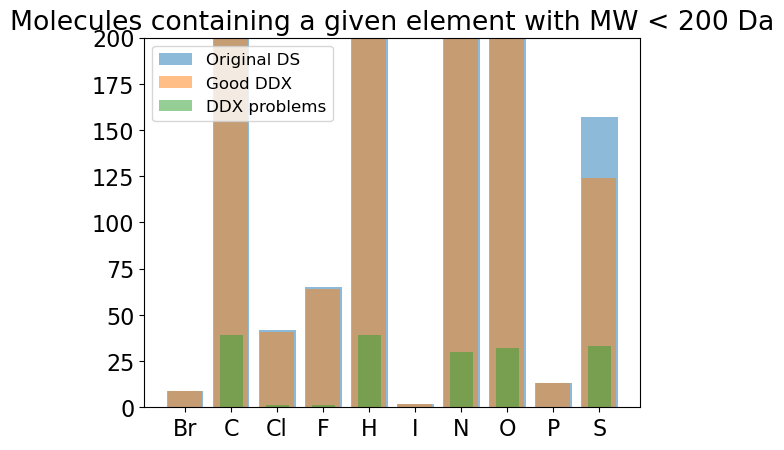

In [118]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=16)

plt.figure()
plt.bar(sm_atoms_unique_labels,sm_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(sm_atoms_unique_good_labels_scaled,sm_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(sm_atoms_unique_prob_labels_scaled,sm_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
# plt.xticks(rotation=90)
plt.title("Molecules containing a given element with MW < 200 Da")
# 
plt.figure()
plt.bar(sm_atoms_unique_labels,sm_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(sm_atoms_unique_good_labels_scaled,sm_atoms_unique_good_counts_scaled,alpha = 0.5,width=0.75,label='Good DDX (scaled)')
plt.bar(sm_atoms_unique_prob_labels_scaled,sm_atoms_unique_prob_counts_scaled,alpha = 0.5,width=0.5, label = 'DDX problems (scaled)')
plt.legend()
plt.title("Molecules containing a given element with MW < 200 Da")
plt.ylim(0,200)
# plt.xticks(rotation=90)
plt.show()

plt.figure()
plt.bar(sm_atoms_unique_labels,sm_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(sm_atoms_unique_good_labels,sm_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(sm_atoms_unique_prob_labels,sm_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
plt.xticks(rotation=90)
plt.title("Molecules containing a given element with MW < 200 Da")
# 
plt.figure()
plt.bar(sm_atoms_unique_labels,sm_atoms_unique_counts,alpha = 0.5,label='Original DS')
plt.bar(sm_atoms_unique_good_labels,sm_atoms_unique_good_counts,alpha = 0.5,width=0.75,label='Good DDX')
plt.bar(sm_atoms_unique_prob_labels,sm_atoms_unique_prob_counts,alpha = 0.5,width=0.5, label = 'DDX problems')
plt.legend()
plt.title("Molecules containing a given element with MW < 200 Da")
plt.ylim(0,200)
# plt.xticks(rotation=90)
plt.show()

### Functional group

Note that to run this, checkmol must be downloaded and installed separately

In [330]:
import openff.evaluator

In [331]:
from openff.evaluator.utils import checkmol

In [332]:
env_dict_all = {}
for smi in vac_smiles_wb97_all:
    envs = checkmol.analyse_functional_groups(smi)
    for key in envs.keys():
        if key in env_dict_all: 
            env_dict_all[key] += envs[key]
        else:
            env_dict_all[key] = envs[key]

In [333]:
env_dict_good = {}
for smi in vac_smiles_wb97_good:
    envs = checkmol.analyse_functional_groups(smi)
    for key in envs.keys():
        if key in env_dict_good: 
            env_dict_good[key] += envs[key]
        else:
            env_dict_good[key] = envs[key]

In [334]:
env_dict_prob = {}
for smi in vac_smiles_wb97_prob:
    envs = checkmol.analyse_functional_groups(smi)
    for key in envs.keys():
        if key in env_dict_prob: 
            env_dict_prob[key] += envs[key]
        else:
            env_dict_prob[key] = envs[key]

In [335]:
env_labels = []
env_counts_all = []
env_counts_good = []
env_counts_prob = []
for key in env_dict_all.keys():
    n_all = env_dict_all[key]
    n_good = 0
    n_prob = 0
    if key in env_dict_good: 
        n_good = env_dict_good[key]
    if key in env_dict_prob:
        n_prob = env_dict_prob[key]
    if n_prob != 0 and n_prob/n_all > 0.1:
        print('{:25s}  {: 3n}  {: 3n}  {: 3n}  {: <5.3f}  {: <5.3f}'.format(str(key).replace('ChemicalEnvironment.',''), n_all, n_good, n_prob, n_good/n_all, n_prob/n_all))
        env_labels.append(str(key).replace('ChemicalEnvironment.',''))
        env_counts_all.append(n_all)
        env_counts_good.append(n_good)
        env_counts_prob.append(n_prob)

ArylIodide                  48   38   10  0.792  0.208
Anion                       86   64   22  0.744  0.256
SulfinicAcidDeriv           20   11    9  0.550  0.450
SulfinicAcid                20   11    9  0.550  0.450
SulfonicAcidDeriv            8    3    5  0.375  0.625
Sulfonamide                  6    1    5  0.167  0.833
Aminal                       1    0    1  0.000  1.000
AlkylIodide                  5    3    2  0.600  0.400
Thioxohetarene               6    5    1  0.833  0.167
Thioether                   51   38   13  0.745  0.255
CarboxylicAcidAmidine        9    8    1  0.889  0.111
PhosphonicAcidDeriv         10    7    3  0.700  0.300
PhosphonicAcid               6    3    3  0.500  0.500
Thiol                        1    0    1  0.000  1.000
Arylthiol                    1    0    1  0.000  1.000
SulfuricAcidDeriv            2    1    1  0.500  0.500
SulfuricAcidMonoester        1    0    1  0.000  1.000
Iminohetarene                5    4    1  0.800  0.200
ImidoThioe

Eliminating large swaths of sulfur functional groups, though not completely. Should compare this to errors without diffuse functions.

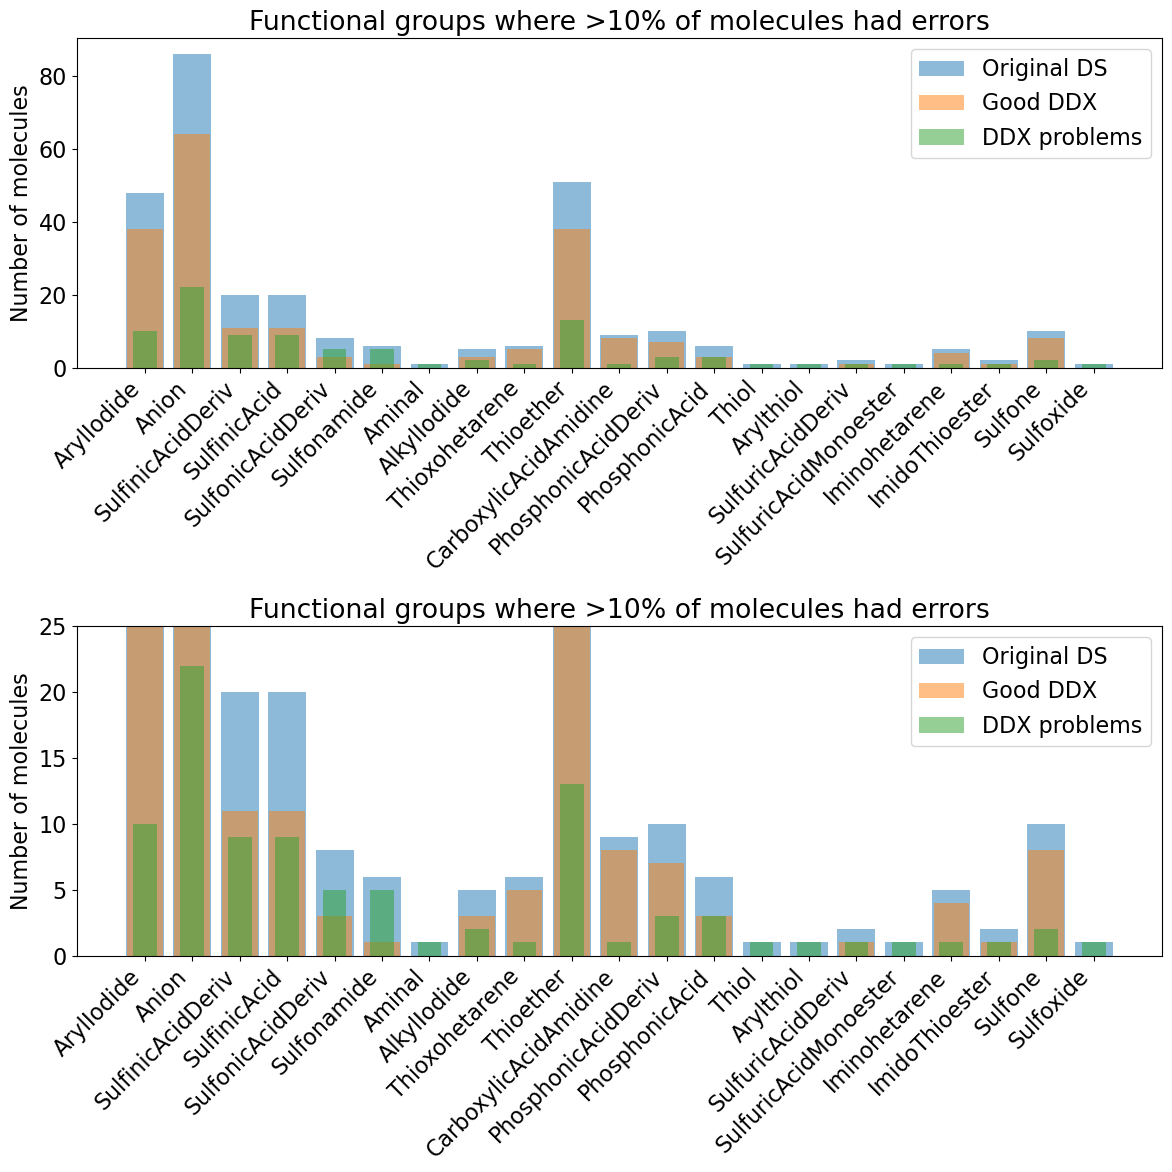

In [379]:
plt.rc('font', size=16) 
plt.rc('legend', fontsize=16)
plt.rc('xtick',labelsize=16)

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,12))
ax1.bar(env_labels,env_counts_all,alpha = 0.5,label='Original DS')
ax1.bar(env_labels,np.array(env_counts_good),alpha = 0.5,width=0.75,label='Good DDX')
ax1.bar(env_labels,np.array(env_counts_prob),alpha = 0.5,width=0.5, label = 'DDX problems')
ax1.legend()
ax1.set_xticks(range(0,len(env_labels)),env_labels,rotation=45,ha='right')
ax1.set_title("Functional groups where >10% of molecules had errors")
ax1.set_ylabel('Number of molecules')

ax2.bar(env_labels,env_counts_all,alpha = 0.5,label='Original DS')
ax2.bar(env_labels,np.array(env_counts_good),alpha = 0.5,width=0.75,label='Good DDX')
ax2.bar(env_labels,np.array(env_counts_prob),alpha = 0.5,width=0.5, label = 'DDX problems')
ax2.legend()
ax2.set_xticks(range(0,len(env_labels)),env_labels,rotation=45,ha='right')
ax2.set_ylim(0,25)
ax2.set_title("Functional groups where >10% of molecules had errors")
ax2.set_ylabel('Number of molecules')

plt.tight_layout()
plt.savefig('functional_groups_dist.png')
plt.show()

# wb97x-D/def2-TZVPP

This was our fallback level of theory. Unfortunately we will not have diffuse functions. 

In [11]:
ddx_dataset_wb97_nodif = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='wb97x-d/def2-TZVPP/ddx-water')

In [13]:
vac_dataset_wb97_nodif = BasicResultCollection.from_server(client=client,datasets=['OpenFF NAGL2 ESP Timing Benchmark v1.1'],spec_name='wb97x-d/def2-TZVPP')

In [14]:
ddx_dataset_wb97_nodif.n_results

1009

In [15]:
vac_dataset_wb97_nodif.n_results

1009

In [16]:
ddx_dataset_wb97_nodif_records = ddx_dataset_wb97_nodif.to_records()

In [17]:
vac_dataset_wb97_nodif_records = vac_dataset_wb97_nodif.to_records()

In [18]:
ddx_wb97_nodif_mol_ids = [record[0].molecule_id for record in ddx_dataset_wb97_nodif_records]

In [19]:
vac_wb97_nodif_mol_ids = [record[0].molecule_id for record in vac_dataset_wb97_nodif_records if record[0].molecule_id in ddx_wb97_nodif_mol_ids]

In [20]:
vac_records_wb97_nodif_w_ddx = [record for record in vac_dataset_wb97_nodif_records if record[0].molecule_id in ddx_wb97_nodif_mol_ids]

In [87]:
n_mbis_diff = 0
n_mbis_diff_i = 0
n_lowdin_diff = 0
n_mulliken_diff = 0
n_dipole_diff = 0
# chgdif_qcaid = []
for i,record in enumerate(ddx_dataset_wb97_nodif_records):
    ddx_record = record[0]
    vac_record = vac_records_wb97_nodif_w_ddx[i][0]
    if vac_record.molecule_id != ddx_record.molecule_id: print('False') # Always True

    ddx_mbis = np.array(ddx_record.properties['mbis charges'])
    vac_mbis = np.array(vac_record.properties['mbis charges'])
    
    ddx_lowdin = np.array(ddx_record.properties['lowdin charges'])
    vac_lowdin = np.array(vac_record.properties['lowdin charges'])

    ddx_mulliken = np.array(ddx_record.properties['mulliken charges'])
    vac_mulliken = np.array(vac_record.properties['mulliken charges'])

    ddx_dipole = np.array(ddx_record.properties['wb97x-d dipole'])
    vac_dipole = np.array(vac_record.properties['wb97x-d dipole'])

    ddx_tot_energy = ddx_record.properties['scf_total_energy']
    vac_tot_energy = vac_record.properties['scf_total_energy']

    ddx_dft_energy = ddx_record.properties['dft total energy']
    vac_dft_energy = vac_record.properties['dft total energy']

    ddx_grid_e = ddx_record.properties['grid electrons total']
    vac_grid_e = vac_record.properties['grid electrons total']
    
    ddx_solv_energy = ddx_record.properties['dd solvation energy']
    if np.any(np.abs(vac_mbis - ddx_mbis) > 0.25):
        print('MBIS difference')
        print(record[1].to_smiles())
        print('DDX MBIS:', ddx_mbis)
        print('Vac MBIS:',vac_mbis)
        print('MBIS diff:',np.abs(vac_mbis - ddx_mbis))
        print('Lowd diff:',np.abs(vac_lowdin - ddx_lowdin))
        print('Mull diff:',np.abs(vac_mulliken - ddx_mulliken))
        print('Dip diff: ',np.abs(vac_dipole - ddx_dipole))
       
        print('Delta Etot:',vac_tot_energy-ddx_tot_energy)
        print('Delta Edft:',vac_dft_energy-ddx_dft_energy)
        print('Solv E:    ',ddx_solv_energy)

        print('Vac Nelec grid: ',vac_grid_e)
        print('DDX Nelec grid: ',ddx_grid_e)
        n_mbis_diff += 1
        # chgdif_qcaid.append(vac_record.molecule_id)
        if "I" in record[1].to_smiles():
            n_mbis_diff_i += 1
    
    elif np.any(np.abs(vac_lowdin - ddx_lowdin) > 1):
        print(record[1].to_smiles())
        print(ddx_lowdin)
        print(vac_lowdin)
        print(np.abs(vac_lowdin - ddx_lowdin))
        n_lowdin_diff += 1
        # chgdif_qcaid.append(vac_record.molecule_id)

    elif np.any(np.abs(vac_mulliken - ddx_mulliken) > 1):
        print(record[1].to_smiles())
        print(ddx_mulliken)
        print(vac_mulliken)
        print(np.abs(vac_mulliken - ddx_mulliken))
        n_mulliken_diff += 1
        # chgdif_qcaid.append(vac_record.molecule_id)
    
    elif np.any(np.abs(vac_dipole - ddx_dipole) > 2):
        print('Dipole difference')
        print(record[1].to_smiles())
        print(ddx_dipole)
        print(vac_dipole)
        print('Dip diff: ',np.abs(vac_dipole - ddx_dipole))
        print('MBIS diff:',np.abs(vac_mbis - ddx_mbis))
        print('Lowd diff:',np.abs(vac_lowdin - ddx_lowdin))
        print('Mull diff:',np.abs(vac_mulliken - ddx_mulliken))

       
        print('Delta Etot:',vac_tot_energy-ddx_tot_energy)
        print('Delta Edft:',vac_dft_energy-ddx_dft_energy)
        print('Solv E:    ',ddx_solv_energy)
        n_dipole_diff += 1
        # chgdif_qcaid.append(vac_record.molecule_id)

In [62]:
print('MBIS differences:     ', n_mbis_diff,n_mbis_diff_i)
print('Lowdin differences:   ',n_lowdin_diff)
print('Mulliken differences: ',n_mulliken_diff)
print('Dipole differences:   ', n_dipole_diff)

MBIS differences:      0 0
Lowdin differences:    0
Mulliken differences:  0
Dipole differences:    0


Nothing with MBIS dif > 0.25 or dipole dif > 2.

## Differences for anions

In [90]:
vac_records_wb97_w_ddx_good = [record for record in vac_dataset_wb97_records if record[0].molecule_id in ddx_wb97_mol_ids and record[0].molecule_id not in chgdif_qcaid]

In [91]:
ddx_records_wb97_good = [record for record in ddx_dataset_wb97_records if record[0].molecule_id in ddx_wb97_mol_ids and record[0].molecule_id not in chgdif_qcaid]

In [92]:
vac_records_wb97_nodif_match_good = [record for record in vac_dataset_wb97_nodif_records if record[0].molecule_id in ddx_wb97_mol_ids and record[0].molecule_id not in chgdif_qcaid]

In [93]:
ddx_records_wb97_nodif_match_good = [record for record in ddx_dataset_wb97_nodif_records if record[0].molecule_id in ddx_wb97_mol_ids and record[0].molecule_id not in chgdif_qcaid]

In [108]:
len(ddx_records_wb97_good)

952

In [104]:
len(chgdif_qcaid)

22

In [383]:
def rmsd(x,y):
    return np.sqrt(np.sum((x-y)**2)/len(x))

In [457]:
anion_diffs_dif = []
anion_diffs_nodif = []
anion_ddiffs = []
anion_ddxdiffs = []
anion_vacdiffs = []
for i,record in enumerate(ddx_records_wb97_nodif_match_good):
    if record[1].total_charge.magnitude < 0:
        ddx_record_nodif = record[0]
        vac_record_nodif = vac_records_wb97_nodif_match_good[i][0]

        ddx_record_dif = ddx_records_wb97_good[i][0]
        vac_record_dif = vac_records_wb97_w_ddx_good[i][0]

        assert ddx_record_nodif.molecule_id == vac_record_nodif.molecule_id
        assert ddx_record_dif.molecule_id == vac_record_dif.molecule_id
        assert vac_record_nodif.molecule_id == vac_record_dif.molecule_id
    
        ddx_mbis_nodif = np.array(ddx_record_nodif.properties['mbis charges'])
        vac_mbis_nodif = np.array(vac_record_nodif.properties['mbis charges'])

        ddx_mbis_dif = np.array(ddx_record_dif.properties['mbis charges'])
        vac_mbis_dif = np.array(vac_record_dif.properties['mbis charges'])
        
        mbis_diff_nodif = vac_mbis_nodif - ddx_mbis_nodif
        mbis_diff_dif = vac_mbis_dif - ddx_mbis_dif

        ddmbis = mbis_diff_nodif - mbis_diff_dif
        
        anion_ddiffs.append(rmsd(mbis_diff_nodif,mbis_diff_dif))
        anion_diffs_dif.append(rmsd(vac_mbis_dif, ddx_mbis_dif))
        anion_diffs_nodif.append(rmsd(vac_mbis_nodif, ddx_mbis_nodif))
        anion_ddxdiffs.append(rmsd(ddx_mbis_nodif,ddx_mbis_dif))
        anion_vacdiffs.append(rmsd(vac_mbis_nodif,vac_mbis_dif))

        if rmsd(vac_mbis_nodif,vac_mbis_dif) > 0.05:
            print(vac_records_wb97_nodif_match_good[i][1].total_charge)

        if np.sum(np.abs(ddmbis)) > 1:
            print('Delta: ',np.sum(np.abs(ddmbis)),'No diffuse: ',np.sum(np.abs(mbis_diff_nodif)),'Diffuse: ',np.sum(np.abs(mbis_diff_dif)))
            print('No diffuse functions:\n',mbis_diff_nodif)
            print('Diffuse functions:\n',mbis_diff_dif)
            print(np.any(np.abs(vac_mbis_dif - ddx_mbis_dif) > 0.25),np.any(np.abs(-mbis_diff_dif) > 0.25),record[0].molecule_id in chgdif_qcaid)
            

-1.0 elementary_charge
-1.0 elementary_charge
-2.0 elementary_charge


In [386]:
other_diffs_dif = []
other_diffs_nodif = []
other_ddiffs = []
other_ddxdiffs = []
other_vacdiffs = []
for i,record in enumerate(ddx_records_wb97_nodif_match_good):
    if record[1].total_charge.magnitude >= 0:
        ddx_record_nodif = record[0]
        vac_record_nodif = vac_records_wb97_nodif_match_good[i][0]

        ddx_record_dif = ddx_records_wb97_good[i][0]
        vac_record_dif = vac_records_wb97_w_ddx_good[i][0]
    
        ddx_mbis_nodif = np.array(ddx_record_nodif.properties['mbis charges'])
        vac_mbis_nodif = np.array(vac_record_nodif.properties['mbis charges'])

        ddx_mbis_dif = np.array(ddx_record_dif.properties['mbis charges'])
        vac_mbis_dif = np.array(vac_record_dif.properties['mbis charges'])
        
        mbis_diff_nodif = ddx_mbis_nodif - vac_mbis_nodif
        mbis_diff_dif = ddx_mbis_dif - vac_mbis_dif

        ddmbis = mbis_diff_nodif - mbis_diff_dif

        other_ddiffs.append(rmsd(mbis_diff_nodif,mbis_diff_dif))
        other_diffs_dif.append(rmsd(vac_mbis_dif, ddx_mbis_dif))
        other_diffs_nodif.append(rmsd(vac_mbis_nodif, ddx_mbis_nodif))
        other_ddxdiffs.append(rmsd(ddx_mbis_nodif,ddx_mbis_dif))
        other_vacdiffs.append(rmsd(vac_mbis_nodif,vac_mbis_dif))


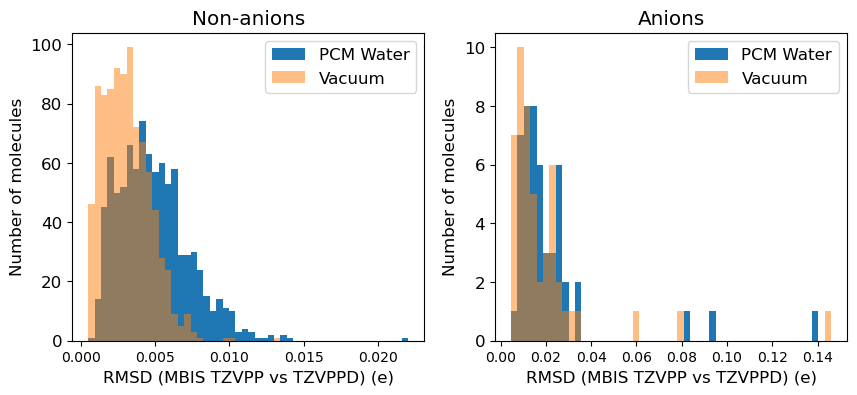

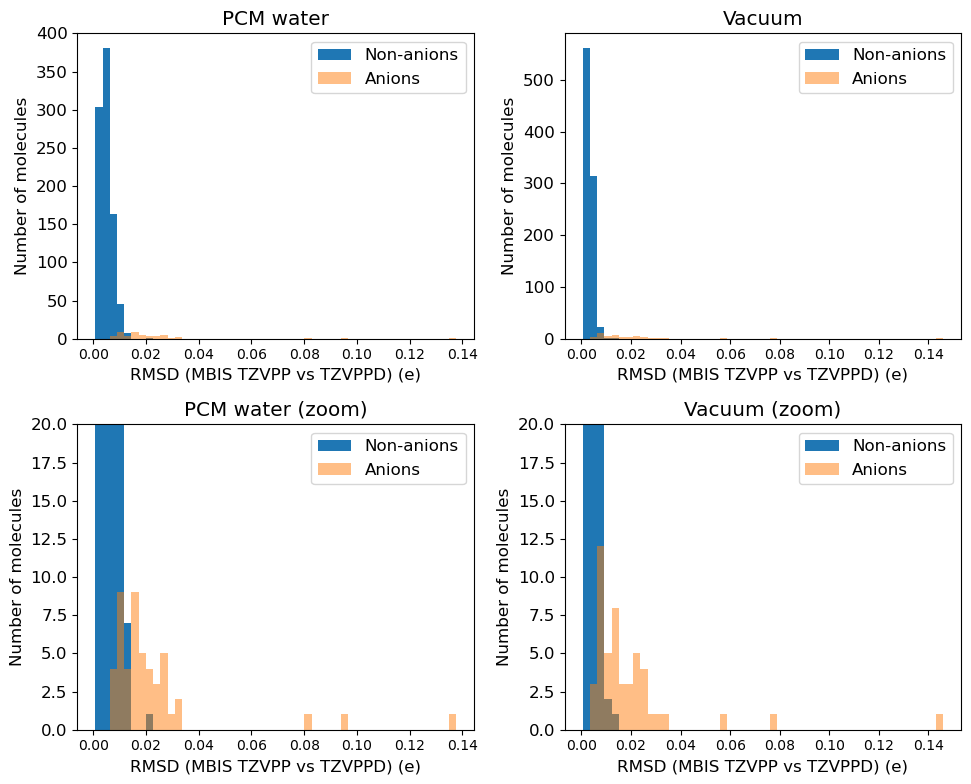

In [449]:
plt.rc('font', size=12) 
plt.rc('legend', fontsize=12)
plt.rc('xtick',labelsize=10)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.hist(other_ddxdiffs,bins=50,range=(min(min(other_ddxdiffs),min(other_vacdiffs)),max(max(other_ddxdiffs),max(other_vacdiffs))),label='PCM Water')
ax1.hist(other_vacdiffs,bins=50,alpha=0.5,range=(min(min(other_ddxdiffs),min(other_vacdiffs)),max(max(other_ddxdiffs),max(other_vacdiffs))),label='Vacuum')
ax1.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax1.set_title('Non-anions')
ax1.set_ylabel('Number of molecules')
ax1.legend()

ax2.hist(anion_ddxdiffs,bins=50,range=(min(min(anion_ddxdiffs),min(anion_vacdiffs)),max(max(anion_ddxdiffs),max(anion_vacdiffs))),label='PCM Water')
ax2.hist(anion_vacdiffs,bins=50,range=(min(min(anion_ddxdiffs),min(anion_vacdiffs)),max(max(anion_ddxdiffs),max(anion_vacdiffs))),alpha=0.5,label='Vacuum')
ax2.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax2.set_title('Anions')
ax2.set_ylabel('Number of molecules')
ax2.legend()
plt.savefig('rmsd_tzvpp_tzvppd_bycharge.png')

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,8))
ax1.hist(other_ddxdiffs,bins=50,range=(min(min(other_ddxdiffs),min(anion_ddxdiffs)),max(max(other_ddxdiffs),max(anion_ddxdiffs))),label='Non-anions')#int(len(other_diffs_dif)/4))
ax1.hist(anion_ddxdiffs,bins=50,range=(min(min(other_ddxdiffs),min(anion_ddxdiffs)),max(max(other_ddxdiffs),max(anion_ddxdiffs))),alpha=0.5,label='Anions')
ax1.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax1.set_title('PCM water')
ax1.set_ylabel('Number of molecules')
ax1.legend()

ax2.hist(other_vacdiffs,bins=50,range=(min(min(other_vacdiffs),min(anion_vacdiffs)),max(max(other_vacdiffs),max(anion_vacdiffs))),label='Non-anions')#int(len(other_diffs_nodif))/4)
ax2.hist(anion_vacdiffs,bins=50,range=(min(min(other_vacdiffs),min(anion_vacdiffs)),max(max(other_vacdiffs),max(anion_vacdiffs))),alpha=0.5,label='Anions')
ax2.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax2.set_title('Vacuum')
ax2.set_ylabel('Number of molecules')
ax2.legend()

ax3.hist(other_ddxdiffs,bins=50,range=(min(min(other_ddxdiffs),min(anion_ddxdiffs)),max(max(other_ddxdiffs),max(anion_ddxdiffs))),label='Non-anions')#int(len(other_diffs_dif)/4))
ax3.hist(anion_ddxdiffs,bins=50,range=(min(min(other_ddxdiffs),min(anion_ddxdiffs)),max(max(other_ddxdiffs),max(anion_ddxdiffs))),alpha=0.5,label='Anions')
ax3.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax3.set_title('PCM water (zoom)')
ax3.set_ylabel('Number of molecules')
ax3.set_ylim(0,20)
ax3.legend()

ax4.hist(other_vacdiffs,bins=50,range=(min(min(other_vacdiffs),min(anion_vacdiffs)),max(max(other_vacdiffs),max(anion_vacdiffs))),label='Non-anions')#int(len(other_diffs_nodif))/4)
ax4.hist(anion_vacdiffs,bins=50,range=(min(min(other_vacdiffs),min(anion_vacdiffs)),max(max(other_vacdiffs),max(anion_vacdiffs))),alpha=0.5,label='Anions')
ax4.set_xlabel('RMSD (MBIS TZVPP vs TZVPPD) (e)')
ax4.set_title('Vacuum (zoom)')
ax4.set_ylabel('Number of molecules')
ax4.set_ylim(0,20)
ax4.legend()

plt.tight_layout()
plt.savefig('rmsd_tzvpp_tzvppd_bysolv.png')

plt.show()

In [458]:
print(np.mean(other_ddxdiffs),np.median(other_ddxdiffs),np.min(other_ddxdiffs),np.max(other_ddxdiffs),np.std(other_ddxdiffs))
print(np.mean(other_vacdiffs),np.median(other_vacdiffs),np.min(other_vacdiffs),np.max(other_vacdiffs),np.std(other_vacdiffs))
print(np.mean(anion_ddxdiffs),np.median(anion_ddxdiffs),np.min(anion_ddxdiffs),np.max(anion_ddxdiffs),np.std(anion_ddxdiffs))
print(np.mean(anion_vacdiffs),np.median(anion_vacdiffs),np.min(anion_vacdiffs),np.max(anion_vacdiffs),np.std(anion_vacdiffs))

0.004869186343831487 0.004573246830998045 0.0008466306497787577 0.022060152621447546 0.0024112932340857
0.003064194616007248 0.0029384817749628245 0.0004755928427581109 0.013018245921919963 0.0015788809994548804
0.02264054777428859 0.016005532101993302 0.0071930115180599144 0.13750447292027745 0.02271903634369885
0.019601441744543945 0.012472751296583373 0.004574609389947881 0.14594457766404303 0.02242202725215882


Large difference in the absolute charges for anions, regardless of solvation, when you add diffuse functions.

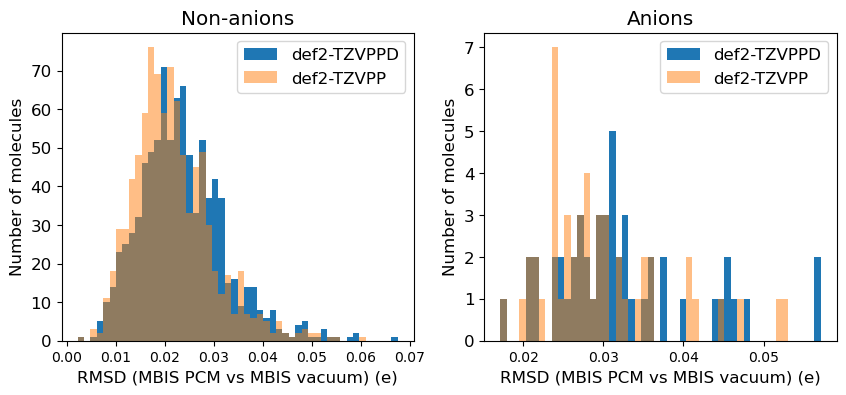

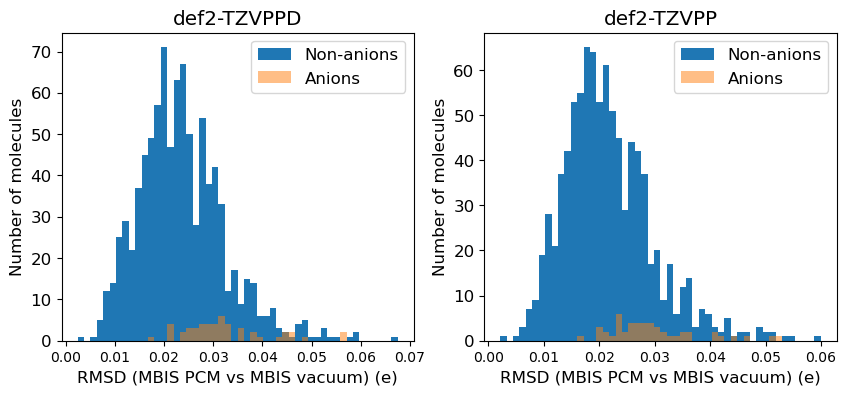

In [450]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.hist(other_diffs_dif,bins=50,range=(min(min(other_diffs_dif),min(other_diffs_nodif)),max(max(other_diffs_dif),max(other_diffs_nodif))),label='def2-TZVPPD')
ax1.hist(other_diffs_nodif,bins=50,range=(min(min(other_diffs_dif),min(other_diffs_nodif)),max(max(other_diffs_dif),max(other_diffs_nodif))),alpha=0.5,label='def2-TZVPP')
ax1.legend()
ax1.set_title('Non-anions')
ax1.set_xlabel('RMSD (MBIS PCM vs MBIS vacuum) (e)')
ax1.set_ylabel('Number of molecules')

ax2.hist(anion_diffs_dif,bins=50,range=(min(min(anion_diffs_dif),min(anion_diffs_nodif)),max(max(anion_diffs_dif),max(anion_diffs_nodif))),label='def2-TZVPPD')
ax2.hist(anion_diffs_nodif,bins=50,range=(min(min(anion_diffs_dif),min(anion_diffs_nodif)),max(max(anion_diffs_dif),max(anion_diffs_nodif))),alpha=0.5,label='def2-TZVPP')
ax2.legend()
ax2.set_title('Anions')
ax2.set_xlabel('RMSD (MBIS PCM vs MBIS vacuum) (e)')
ax2.set_ylabel('Number of molecules')
plt.savefig('rmsd_pcm_vac_bycharge.png')

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.hist(other_diffs_dif,bins=50,range=(min(min(other_diffs_dif),min(anion_diffs_dif)),max(max(other_diffs_dif),max(anion_diffs_dif))),label='Non-anions')
ax1.hist(anion_diffs_dif,bins=50,range=(min(min(other_diffs_dif),min(anion_diffs_dif)),max(max(other_diffs_dif),max(anion_diffs_dif))),alpha=0.5,label='Anions')
ax1.legend()
ax1.set_title('def2-TZVPPD')
ax1.set_xlabel('RMSD (MBIS PCM vs MBIS vacuum) (e)')
ax1.set_ylabel('Number of molecules')

ax2.hist(other_diffs_nodif,bins=50,range=(min(min(other_diffs_nodif),min(anion_diffs_nodif)),max(max(other_diffs_nodif),max(anion_diffs_nodif))),label='Non-anions')
ax2.hist(anion_diffs_nodif,bins=50,range=(min(min(other_diffs_nodif),min(anion_diffs_nodif)),max(max(other_diffs_nodif),max(anion_diffs_nodif))),alpha=0.5,label='Anions')
ax2.legend()
ax2.set_title('def2-TZVPP')
ax2.set_xlabel('RMSD (MBIS PCM vs MBIS vacuum) (e)')
ax2.set_ylabel('Number of molecules')
plt.savefig('rmsd_pcm_vac_bybasis.png')

plt.show()

In [459]:
print(np.mean(other_diffs_dif),np.median(other_diffs_dif),np.min(other_diffs_dif),np.max(other_diffs_dif),np.std(other_diffs_dif))
print(np.mean(other_diffs_nodif),np.median(other_diffs_nodif),np.min(other_diffs_nodif),np.max(other_diffs_nodif),np.std(other_diffs_nodif))
print(np.mean(anion_diffs_dif),np.median(anion_diffs_dif),np.min(anion_diffs_dif),np.max(anion_diffs_dif),np.std(anion_diffs_dif))
print(np.mean(anion_diffs_nodif),np.median(anion_diffs_nodif),np.min(anion_diffs_nodif),np.max(anion_diffs_nodif),np.std(anion_diffs_nodif))

0.023572272914223293 0.022621548640541438 0.0024033461688585155 0.06753450930172634 0.008809536926100514
0.021604862238978607 0.0205673239289515 0.002127549048231677 0.05991094272951027 0.008091521702827129
0.032388886638902346 0.030819410733211337 0.01755946967894312 0.05711300497926454 0.008676375626668197
0.029700199029473847 0.027808888601553408 0.017115149025872092 0.05271961168520338 0.007905629432896022


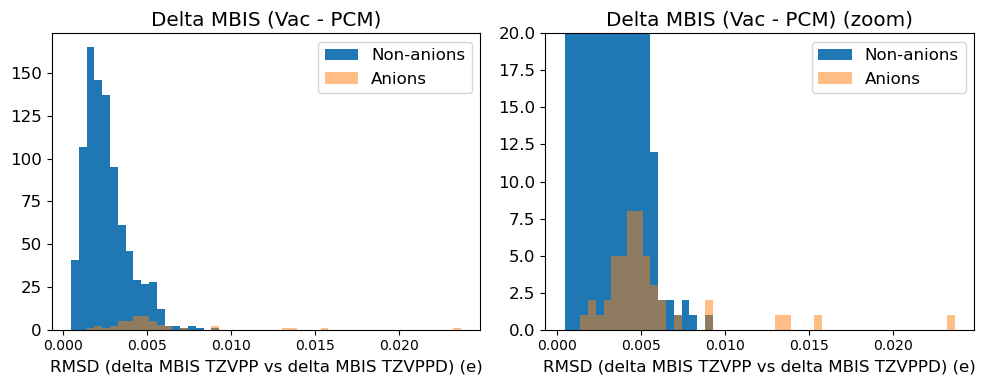

In [451]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
ax1.hist(other_ddiffs,bins=50,range=(min(min(other_ddiffs),min(anion_ddiffs)),max(max(other_ddiffs),max(anion_ddiffs))),label = 'Non-anions')
ax1.hist(anion_ddiffs,bins=50,range=(min(min(other_ddiffs),min(anion_ddiffs)),max(max(other_ddiffs),max(anion_ddiffs))),alpha = 0.5,label='Anions')
ax1.set_title('Delta MBIS (Vac - PCM)')
ax1.legend()
ax1.set_xlabel('RMSD (delta MBIS TZVPP vs delta MBIS TZVPPD) (e)')

ax2.hist(other_ddiffs,bins=50,range=(min(min(other_ddiffs),min(anion_ddiffs)),max(max(other_ddiffs),max(anion_ddiffs))),label = 'Non-anions')
ax2.hist(anion_ddiffs,bins=50,range=(min(min(other_ddiffs),min(anion_ddiffs)),max(max(other_ddiffs),max(anion_ddiffs))),alpha = 0.5,label='Anions')
ax2.set_title('Delta MBIS (Vac - PCM) (zoom)')
ax2.set_xlabel('RMSD (delta MBIS TZVPP vs delta MBIS TZVPPD) (e)')
ax2.legend()
ax2.set_ylim(0,20)

plt.tight_layout()
plt.savefig('rmsd_delta_mbis.png')
plt.show()

No big difference in the charge polarization due to the solvent. Diffuse vs non-diffuse basis charges change about the same amount.